In [1]:
import random
import time
import os
import sys
# Automatically find and add the project root directory to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from tsai.all import *
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.vision.all import *
from torch.utils.data.dataset import ConcatDataset
from tsai.utils import set_seed
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d
# from aeon.datasets import load_classification
# from sktime.datasets import load_UCR_UEA_dataset
from lomatce.explainer import LomatceExplainer
import lomatce.perturbation as perturbation 
import lomatce.utils.test_dataloader as test_loader




set_seed(1024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"device: {device}")
my_setup()

device: cuda
os              : Windows-10-10.0.26100-SP0
python          : 3.11.13
tsai            : 0.3.9
fastai          : 2.7.14
fastcore        : 1.5.29
torch           : 2.2.2+cu118
device          : 1 gpu (['NVIDIA GeForce RTX 4050 Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.68 GB
GPU memory      : [6.0] GB


In [2]:
# Set a random seed to ensure that the results are reproducible
random_seed = 45

torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

In [3]:
# List of univariate datasets from UCR archive
print(get_UCR_univariate_list())

# List of multivariate datasets from UCR archieve
print(get_UCR_multivariate_list())

['ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGestureWiimoteZ', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken', 'BME', 'Car', 'CBF', 'Chinatown', 'ChlorineConcentration', 'CinCECGTorso', 'Coffee', 'Computers', 'CricketX', 'CricketY', 'CricketZ', 'Crop', 'DiatomSizeReduction', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW', 'DodgerLoopDay', 'DodgerLoopGame', 'DodgerLoopWeekend', 'Earthquakes', 'ECG200', 'ECG5000', 'ECGFiveDays', 'ElectricDevices', 'EOGHorizontalSignal', 'EOGVerticalSignal', 'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords', 'Fish', 'FordA', 'FordB', 'FreezerRegularTrain', 'FreezerSmallTrain', 'Fungi', 'GestureMidAirD1', 'GestureMidAirD2', 'GestureMidAirD3', 'GesturePebbleZ1', 'GesturePebbleZ2', 'GunPoint', 'GunPointAgeSpan', 'GunPointMaleVersusFemale', 'GunPointOldVersusYoung', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate', 'InsectEPGRegularTrain', 'InsectEPGSmallTrain', 'I

In [5]:
dsid= 'ECG200' # dataset id/name
dataset_name = dsid.lower()
model = 'FCN'.lower()

cur_time = time.strftime('%Y-%m-%d_%H-%M-%S')
if 'cuda' in str(device):
    base_dir = f'results/{dataset_name}/{model}--{cur_time}' 
else:
    base_dir = f'results/ecg200--2023-12-28_16-37-54' 
#Create the base directory if not exist
os.makedirs(base_dir, exist_ok=True)

In [6]:

X, y, splits  = get_UCR_data(dsid, on_disk=True, return_split=False)

In [7]:
unique_classes, counts = np.unique(y, return_counts=True)
for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count} instances")

Class -1: 67 instances
Class 1: 133 instances


### Load and preprocess data

In [ ]:
def data_preparation(X, y, test_size=0.4, random_state=12):
    # Stratified split to maintain class distribution
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
    # Validation set is required in fastai
    X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.4, stratify=y_test, random_state=random_state)

    print(f'Shape of X_train :{X_train.shape}')
    print(f'Shape of y_train :{y_train.shape}')
    print(f'Shape of X_valid :{X_valid.shape}')
    print(f'Shape of X_test :{X_test.shape}')

    tfms  = [None, [Categorize()]]
    train_ds = TSDatasets(X_train, y_train, tfms=tfms)
    valid_ds = TSDatasets(X_valid, y_valid, tfms=tfms)


    dls = TSDataLoaders.from_dsets(train_ds, valid_ds, bs=[8, 32], batch_tfms=[TSStandardize()], num_workers=0,  device=device, shuffle=True )
    print(f' Number of classes : {dls.c}')
    return dls, X_train, X_test, y_test

In [9]:
lomatce_explainer = LomatceExplainer(base_dir=base_dir)
dls, X_train, X_test, y_test = data_preparation(X, y)

Shape of X_train :(120, 1, 96)
Shape of y_train :(120,)
Shape of X_valid :(32, 1, 96)
Shape of X_test :(48, 1, 96)
 Number of classes : 2


### Build learner and train model

In [10]:
def trainer (model, dls, epochs=100, learning_rate=1e-3, patience=15):
    kwargs = {}
    metrics=[accuracy]
    path = f'{base_dir}/export'
    os.makedirs(path, exist_ok=True)
    # Create model
    model = create_model(model, dls=dls, **kwargs)
    # Define early stopping criteria
    early_stopping = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=patience)

    # Define a call back to save the best model
    save_callback = SaveModelCallback(monitor='accuracy')
    # Train and evaluate model with early stopping
    # set_seed(42)
    cbs = [early_stopping, save_callback,ShowGraph()]
    learn = Learner(dls=dls, model=model, opt_func=Adam, metrics=metrics,cbs=cbs) #
    learn.fit_one_cycle(epochs, learning_rate)
    learn.save_all(path=path, dls_fname='dls', model_fname='model', learner_fname='learner')
    return learn

def validator(learn, X_test, y_test):
    dls = learn.dls
    valid_dl = dls.valid
    train_dl = dls.train
    # Labelled test data
    test_ds = valid_dl.dataset.add_test(X_test, y_test)# In this case I'll use X and y, but this would be your test data
    test_dl = valid_dl.new(test_ds)
    test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
    # print(f'Test Accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
    train_probas, train_targets, train_preds = learn.get_preds(dl=train_dl, with_decoded=True)
    
    valid_accuracy = (valid_targets == valid_preds).float().mean()
    test_accuracy = (test_targets == test_preds).float().mean()
    train_accuracy = (train_targets == train_preds).float().mean()

    print(f"Validation Accuracy :{valid_accuracy:.2f}")
    print(f"Test Accuracy :{test_accuracy:.2f}")
    print(f"Train Accuracy :{train_accuracy:.2f}")
    valid_dl.show_batch(sharey=True)
    test_dl.show_batch(sharey=True)
    learn.show_results(max_n=9)

    return train_accuracy, valid_accuracy, test_accuracy, test_preds, valid_preds

Shape of X_train :(120, 1, 96)
Shape of y_train :(120,)
Shape of X_valid :(32, 1, 96)
Shape of X_test :(48, 1, 96)
 Number of classes : 2
Start training...


Better model found at epoch 0 with accuracy value: 0.34375.


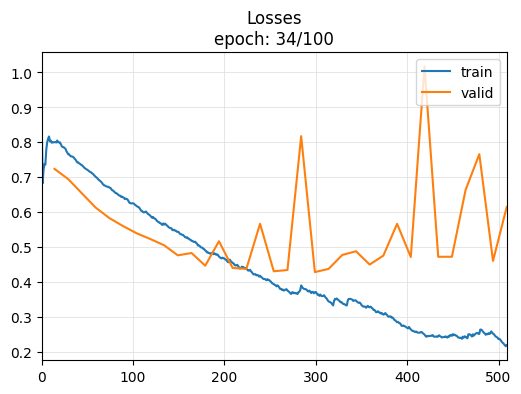

Better model found at epoch 1 with accuracy value: 0.5625.
Better model found at epoch 2 with accuracy value: 0.6875.
Better model found at epoch 8 with accuracy value: 0.71875.
Better model found at epoch 9 with accuracy value: 0.78125.
Better model found at epoch 14 with accuracy value: 0.875.
No improvement since epoch 19: early stopping


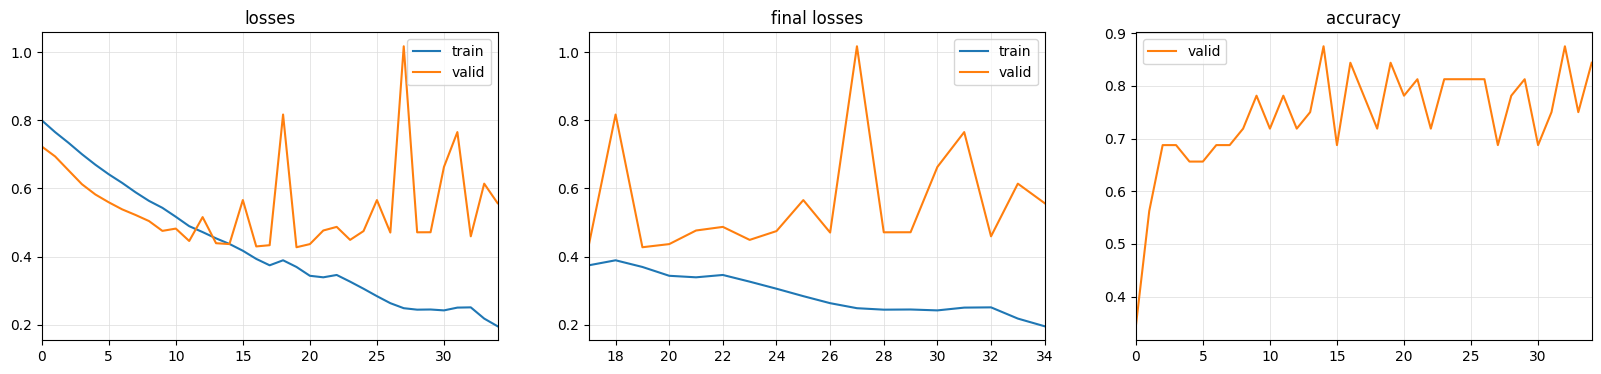

cuda


In [11]:
dls, X_train, X_test, y_test= data_preparation(X, y)
# Run the trainer function only if CUDA is available
if 'cuda' in str(device):
    print('Start training...')
    learn_new = trainer(FCN, dls)
# else:
#     learn_new = load_learner_all(path=f'{base_dir}/export/',
#                                dls_fname='dls', model_fname='model', learner_fname='learner')
    # train_acc, valid_acc, test_acc, test_preds, valid_preds = validator(learn_new, X_test, y_test)
print(device)

Validation Accuracy :0.88
Test Accuracy :0.85
Train Accuracy :0.85


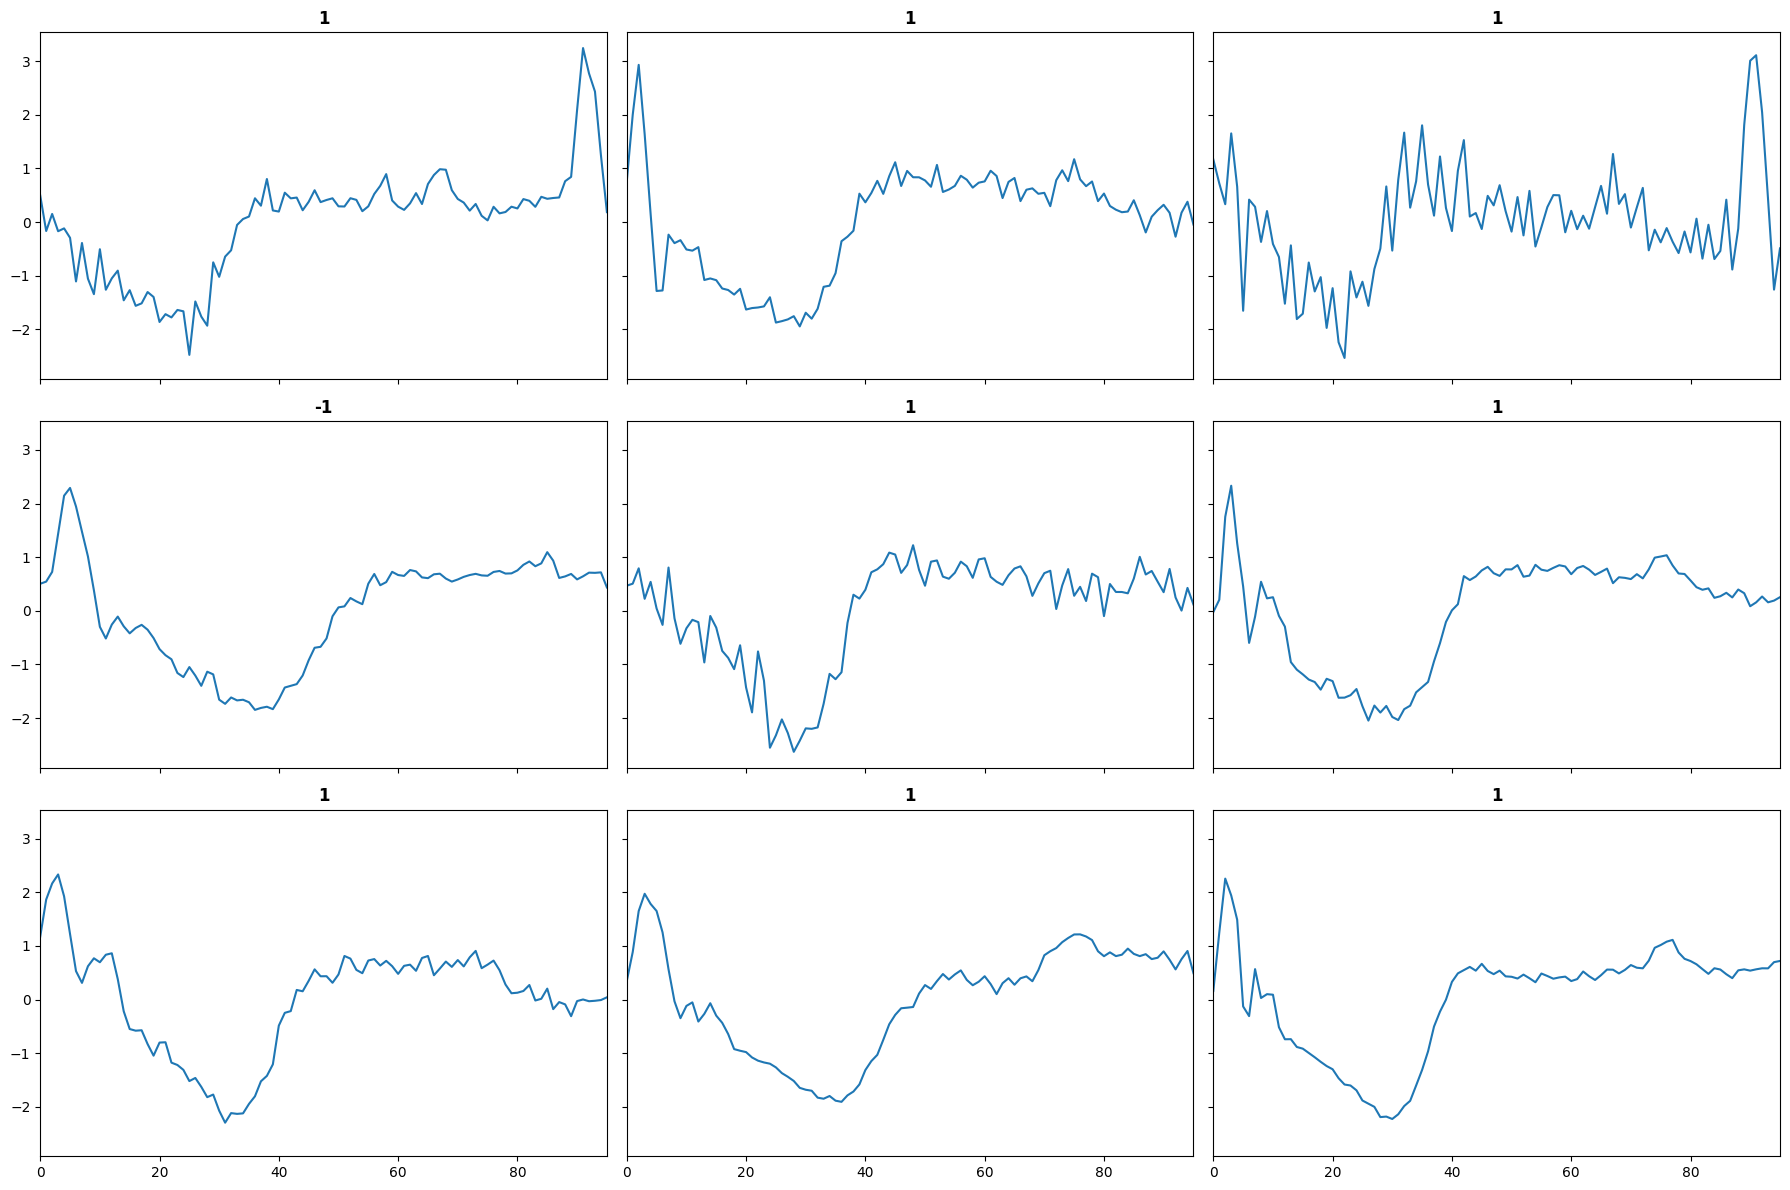

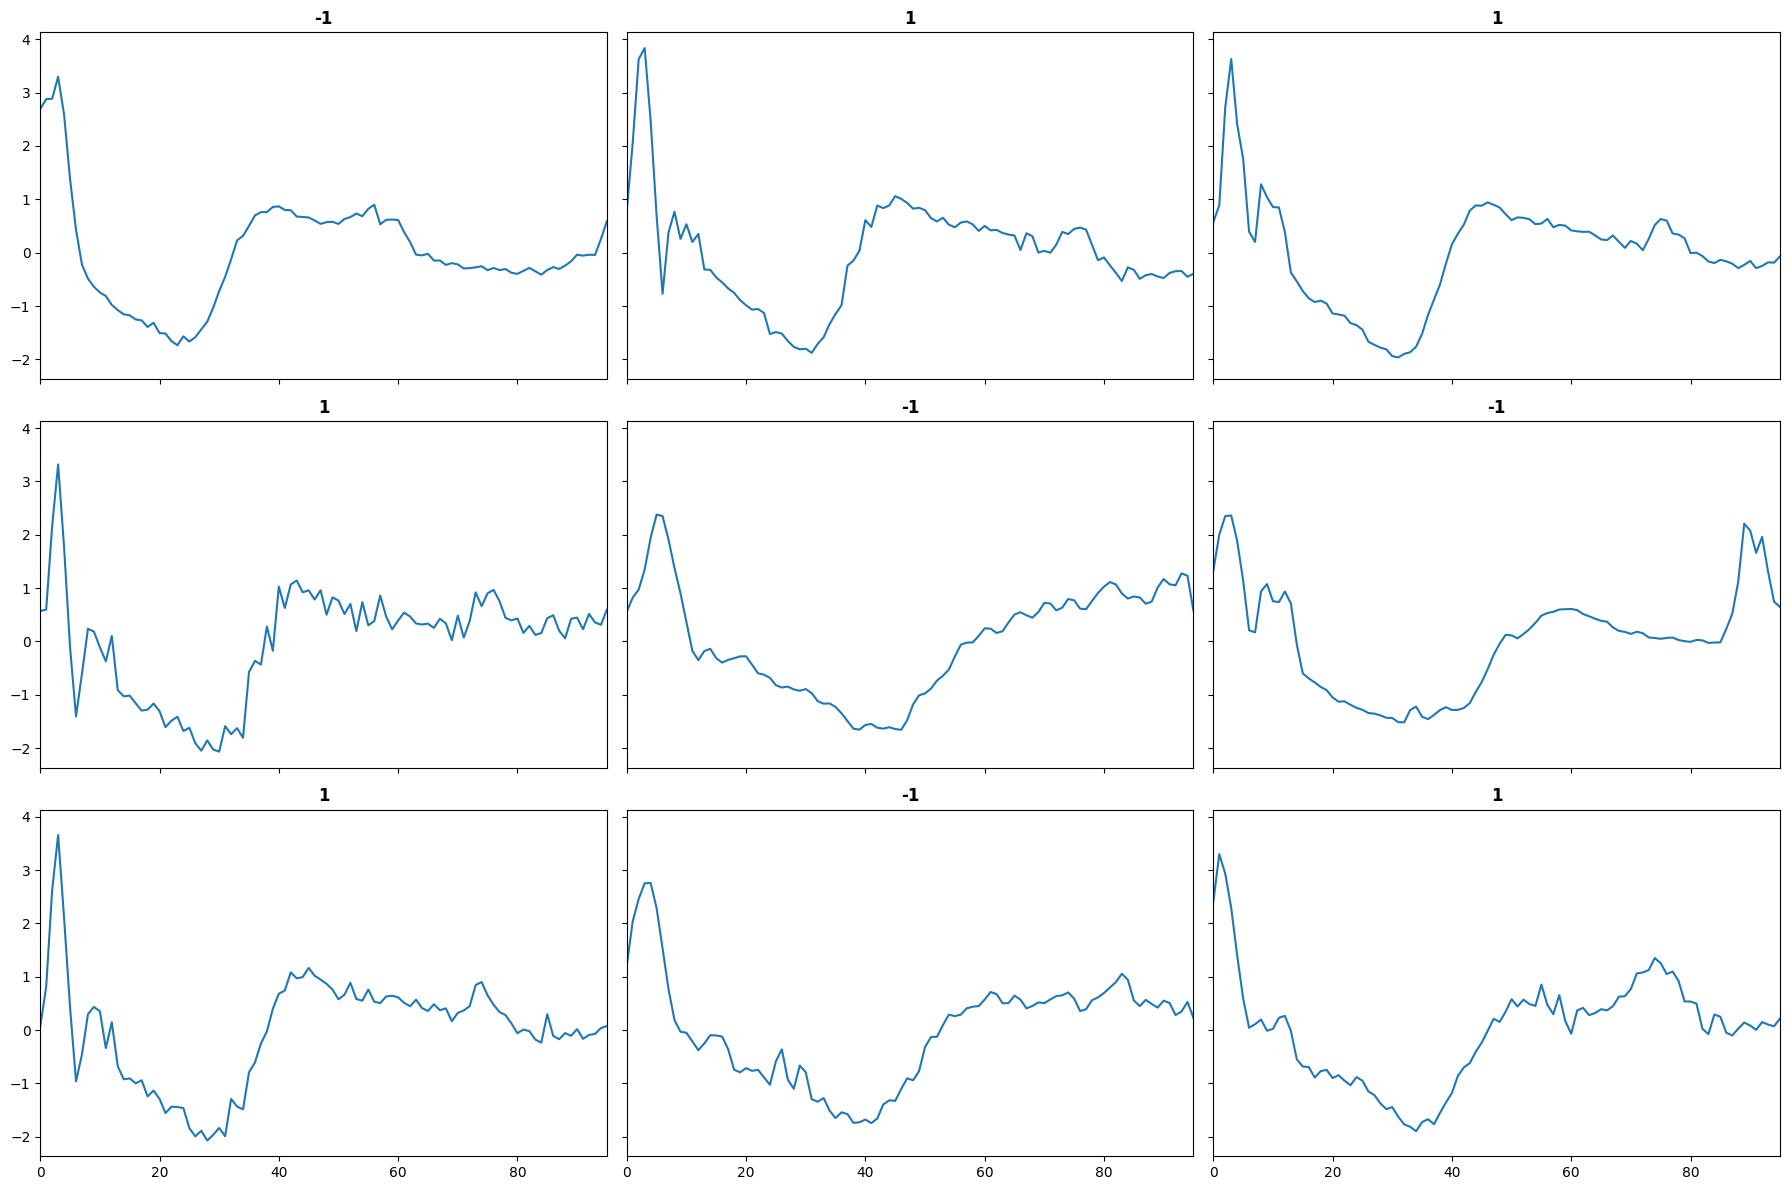

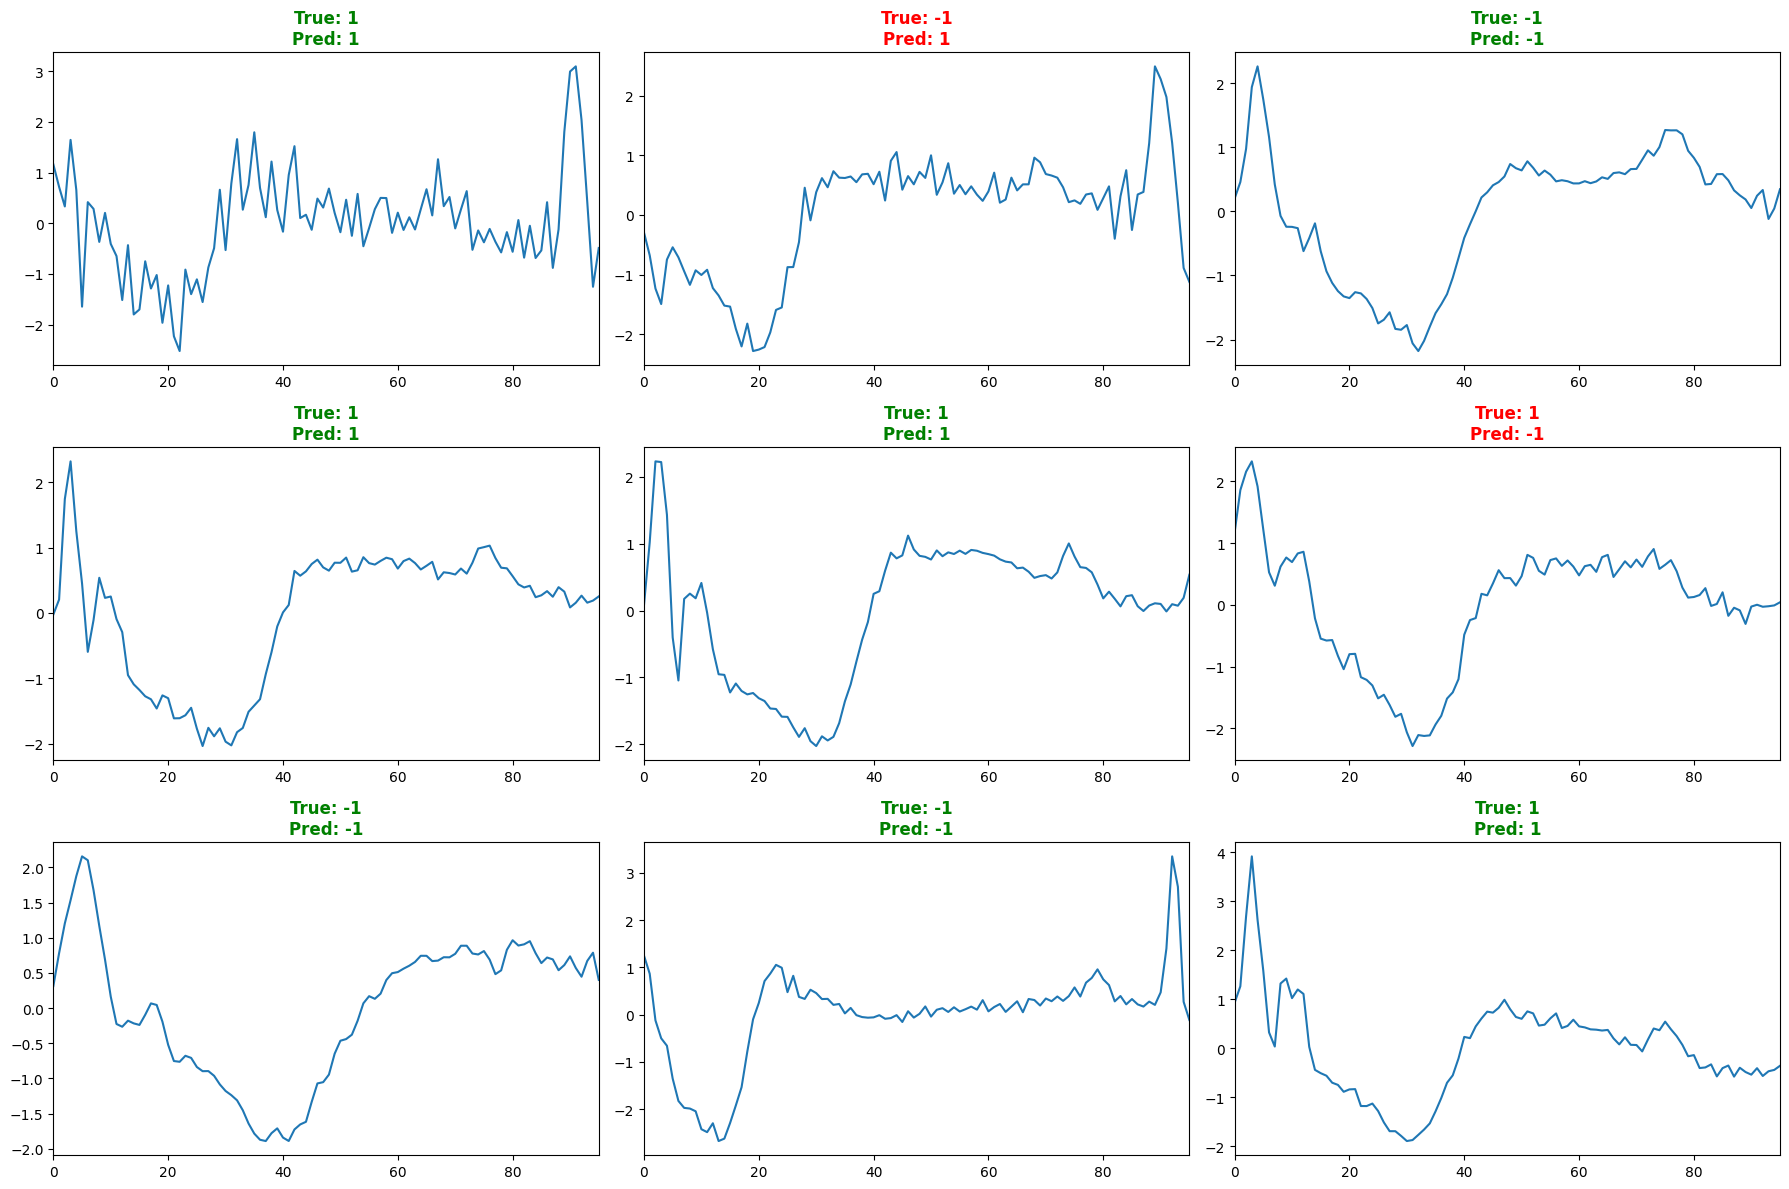

In [12]:
train_acc, valid_acc, test_acc, test_preds, valid_preds = validator(learn_new, X_test, y_test)

In [13]:
learn_new.summary()

not enough values to plot a chart


FCN (Input shape: 8 x 1 x 96)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 128 x 96        
Conv1d                                    896        True      
BatchNorm1d                               256        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 256 x 96        
Conv1d                                    163840     True      
BatchNorm1d                               512        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 128 x 96        
Conv1d                                    98304      True      
BatchNorm1d                               256        True      
ReLU                                                           
__________________________________________________

In [14]:
class_labels = ['Myocardial Infarction','Normal Heartbeat']

In [15]:
def predict_fn(data, learner):
    if len(data.shape) == 2:
        data = data.reshape(data.shape[0], 1, data.shape[1])
    data_dl = test_loader.test_dataloader(learner, data)
    data_probas, _, data_preds = learner.get_preds(dl=data_dl, with_decoded=True, save_preds=None)
    return data_probas, data_preds

### Apply LOMATCE (LOcal Model-Agnostic Time-series Classifers Explanation)
LOMATCE is a novel Explainable AI (XAI) method designed specifically for time series classifiers. It generates explanations that preserve the temporal characteristics of time series data.

INFO:lomatce.explainer:Starting time series local explanation
INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 16 = 16
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 73) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 73


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.93
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.81
INFO:lomatce.explainer:Model Type: Ridge


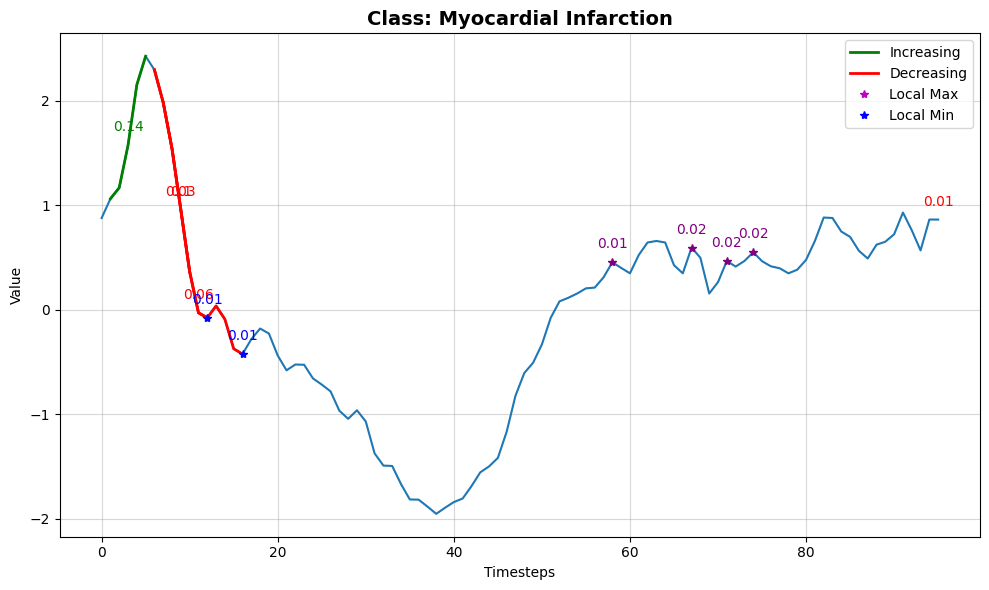

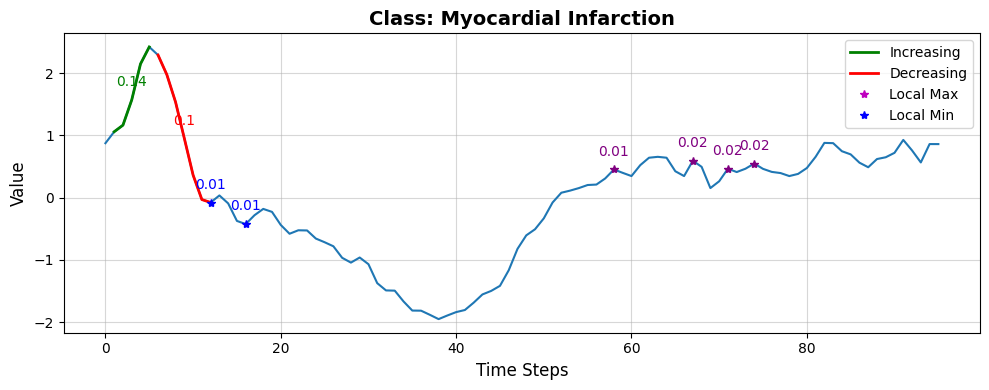

Predection probability : tensor([0.8456, 0.1544])
Myocardial Infarction:                      0.8456
Normal Heartbeat:                      0.1544


In [ ]:
origi_instance_0 = X_test[5] # Instance that is classified as Myocardial Infraction
explanation = lomatce_explainer.explain_instance(origi_instance_0, lambda data: predict_fn(data, learn_new), num_perturbations=1000, top_n=15, class_names=class_labels, replacement_method='zero')

INFO:lomatce.explainer:Starting time series local explanation


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 76) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 76


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.91
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.82
INFO:lomatce.explainer:Model Type: Ridge


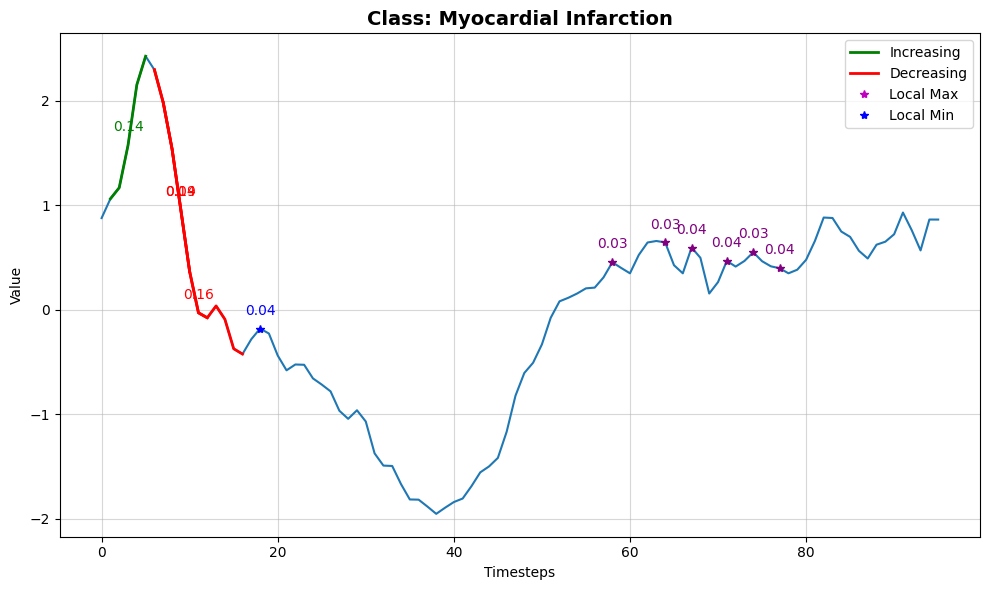

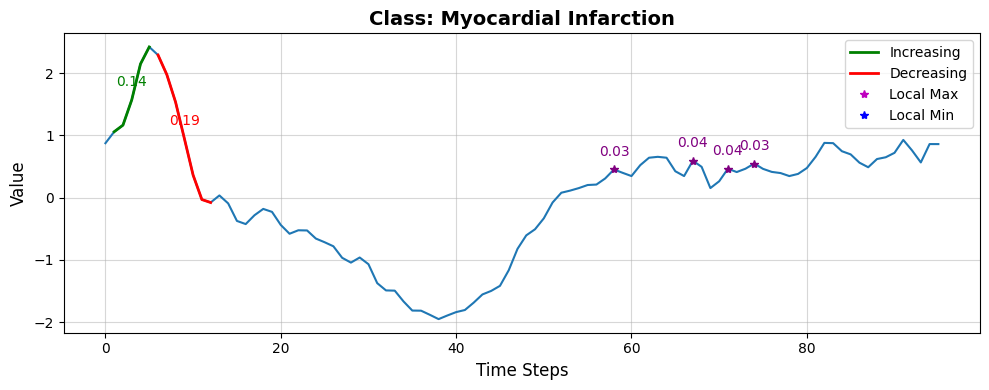

Predection probability : tensor([0.8698, 0.1302])
Myocardial Infarction:                      0.8698
Normal Heartbeat:                      0.1302


In [15]:
origi_instance_0 = X_test[5] # Instance that is classified as Myocardial Infraction
explanation = lomatce_explainer.explain_instance(origi_instance_0, lambda data: predict_fn(data, learn_new), num_perturbations=1000, top_n=15, class_names=class_labels, replacement_method='zero')


📊 Visual 1: Cluster centroids overlaid on the original time series.


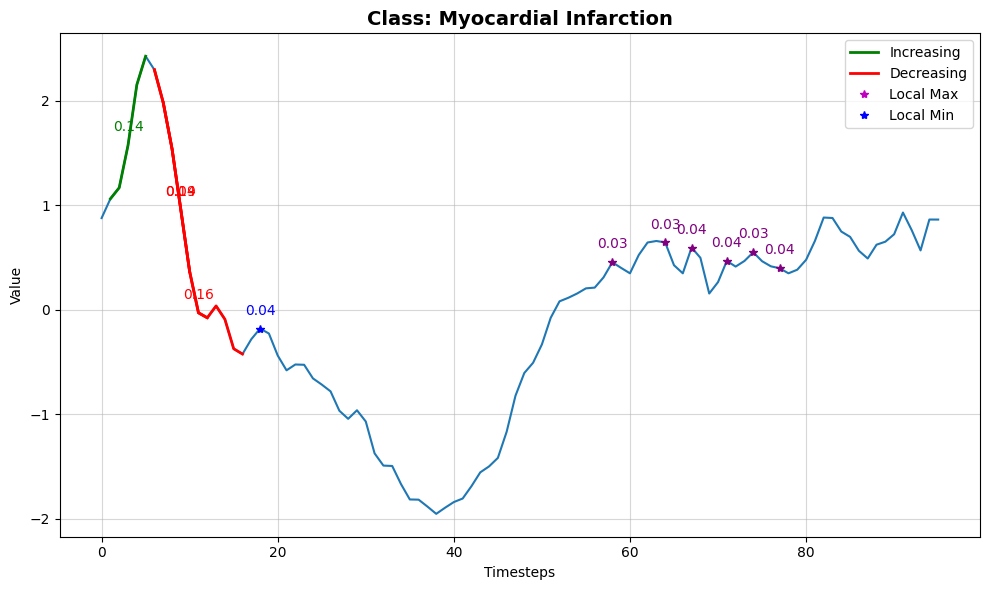

📌 Visual 2: Important events belong to the top-k clusters overlaid on the original time series.


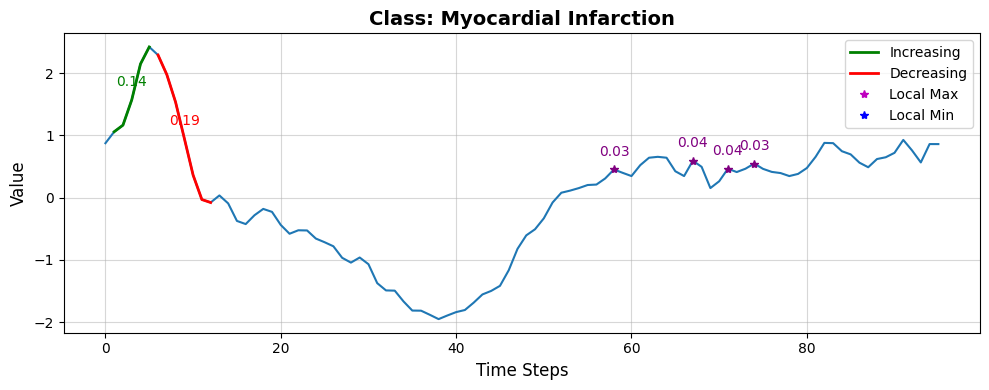

🧠 Explanation Summary:
• Local prediction (interpretable model): 0.8154
• Black-box model prediction: 0 or 'Myocardial Infarction'
• Local fidelity score (R²): 0.9149

 Class Probabilities (from black-box model):
Myocardial Infarction:                      0.8698
Normal Heartbeat:                      0.1302


In [16]:
explanation.visualise(origi_instance_0)

INFO:lomatce.explainer:Starting time series local explanation
INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 76) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 76


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.87
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.84
INFO:lomatce.explainer:Model Type: Ridge


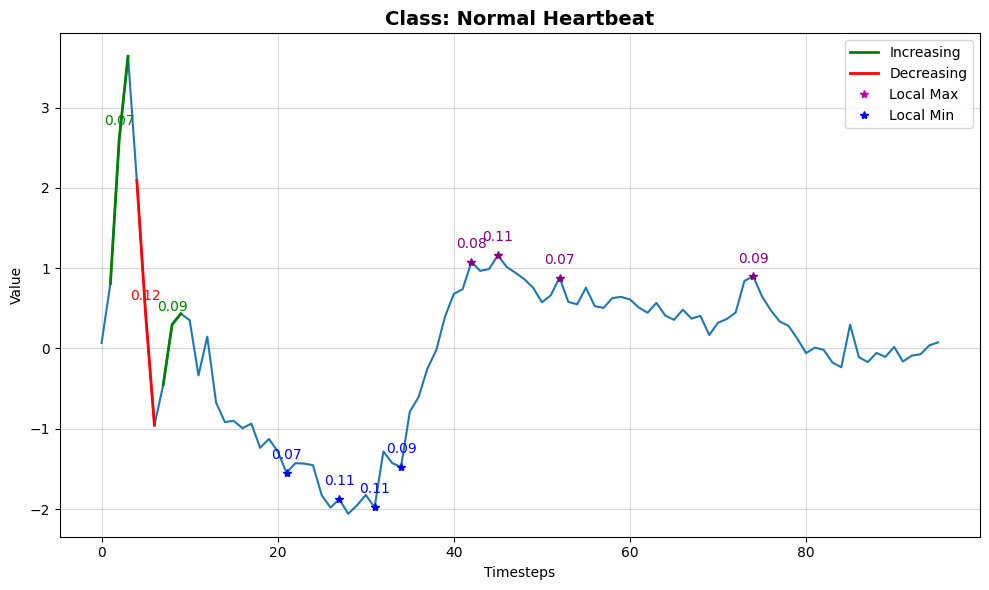

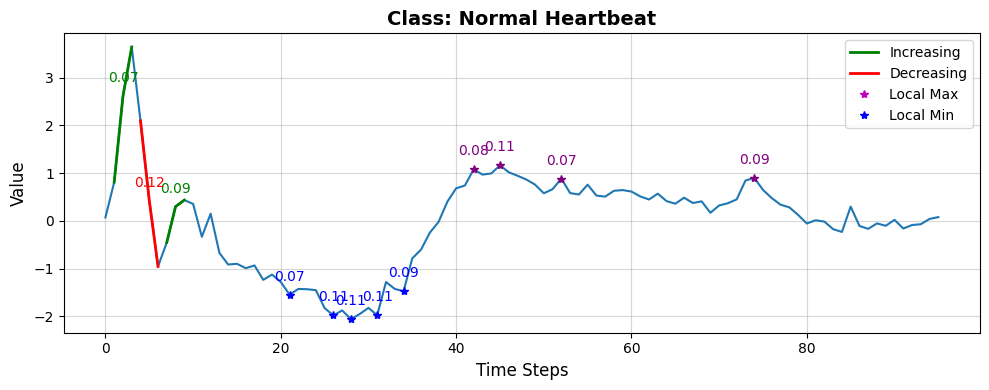

Predection probability : tensor([0.1651, 0.8349])
Myocardial Infarction:                      0.1651
Normal Heartbeat:                      0.8349


In [32]:
origi_instance_1 = X_test[1] # Instance that is classified as Normal heartbeat
explanation = lomatce_explainer.explain_instance(origi_instance_1, lambda data: predict_fn(data, learn_new), num_perturbations=1000, top_n=15, class_names=class_labels, replacement_method='zero')

INFO:lomatce.explainer:Starting time series local explanation


Replacement methods: zero


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 17 = 17
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 74) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 74


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.93
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.82
INFO:lomatce.explainer:Model Type: Ridge


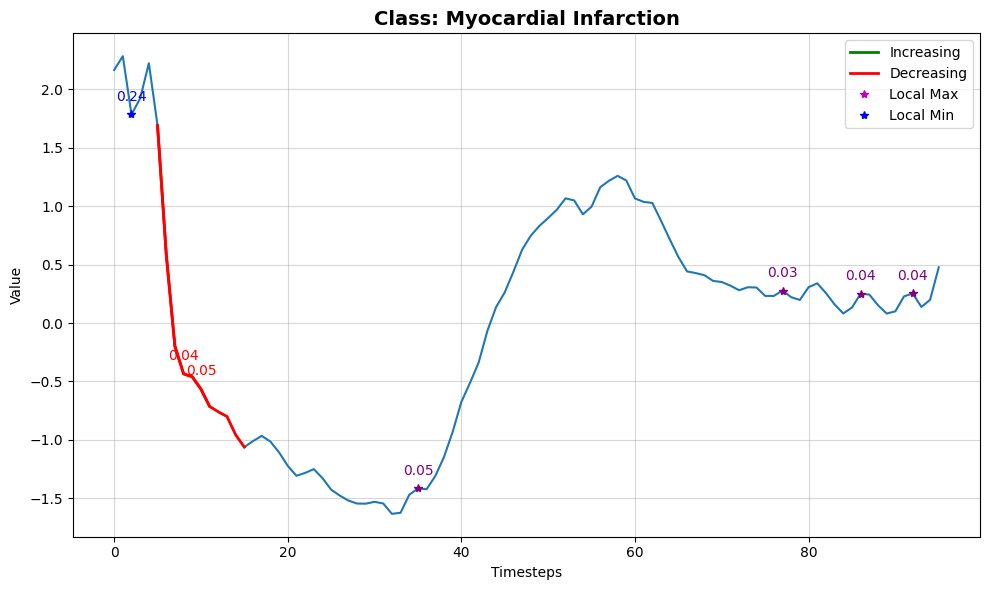

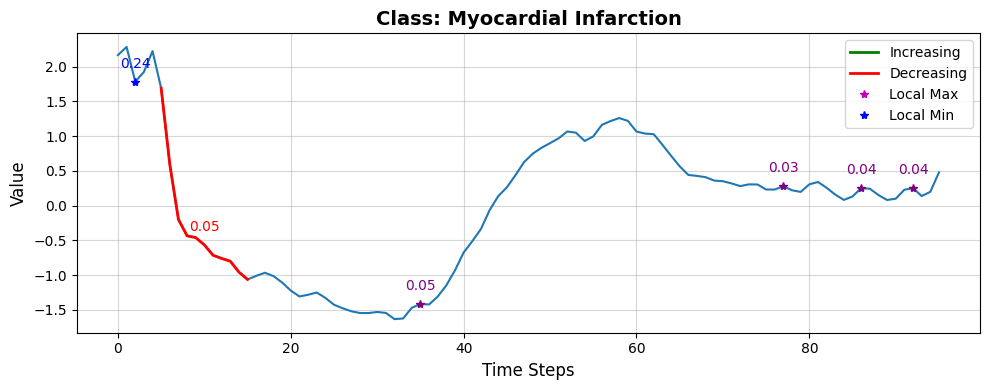

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.8632, 0.1368])
Myocardial Infarction:                      0.8632
Normal Heartbeat:                      0.1368


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 16 = 16
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 73) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 73


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.89
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.54
INFO:lomatce.explainer:Model Type: Ridge


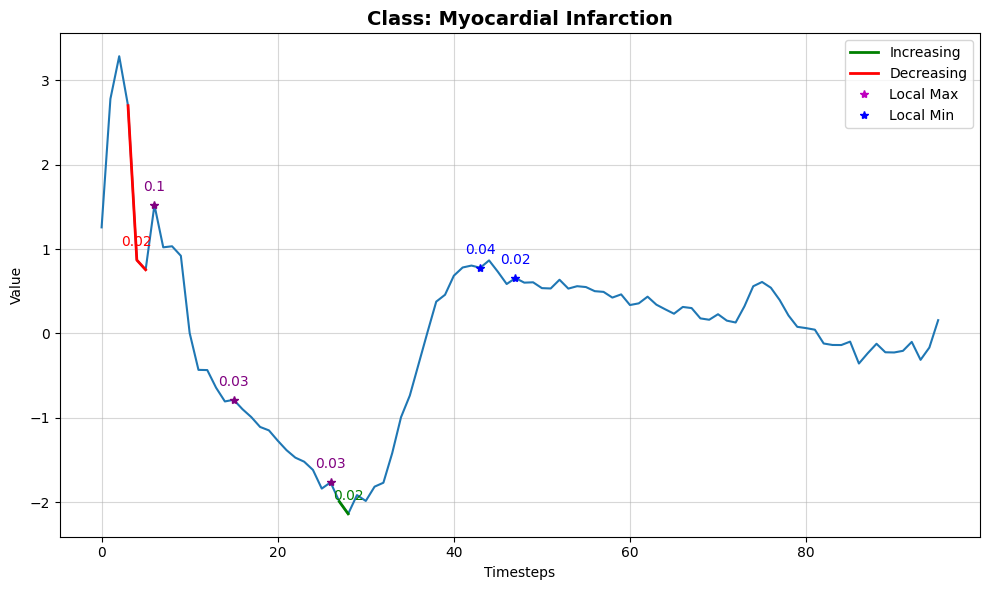

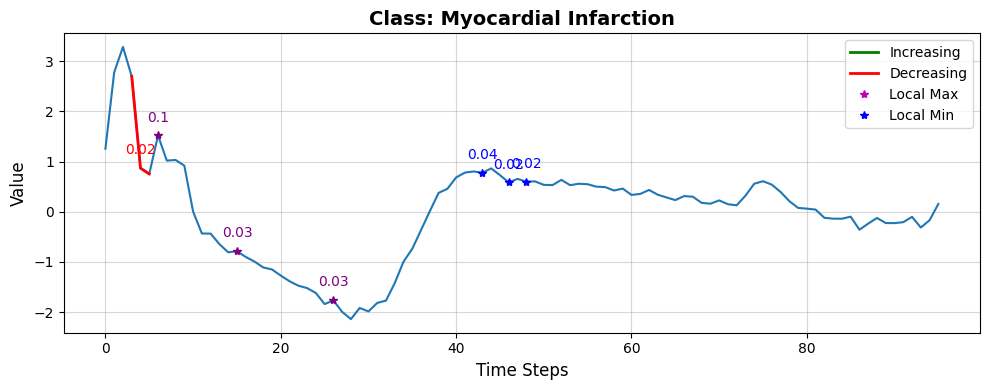

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.5666, 0.4334])
Myocardial Infarction:                      0.5666
Normal Heartbeat:                      0.4334


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 17 = 17
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 18 = 18
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 73) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 73


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.93
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.61
INFO:lomatce.explainer:Model Type: Ridge


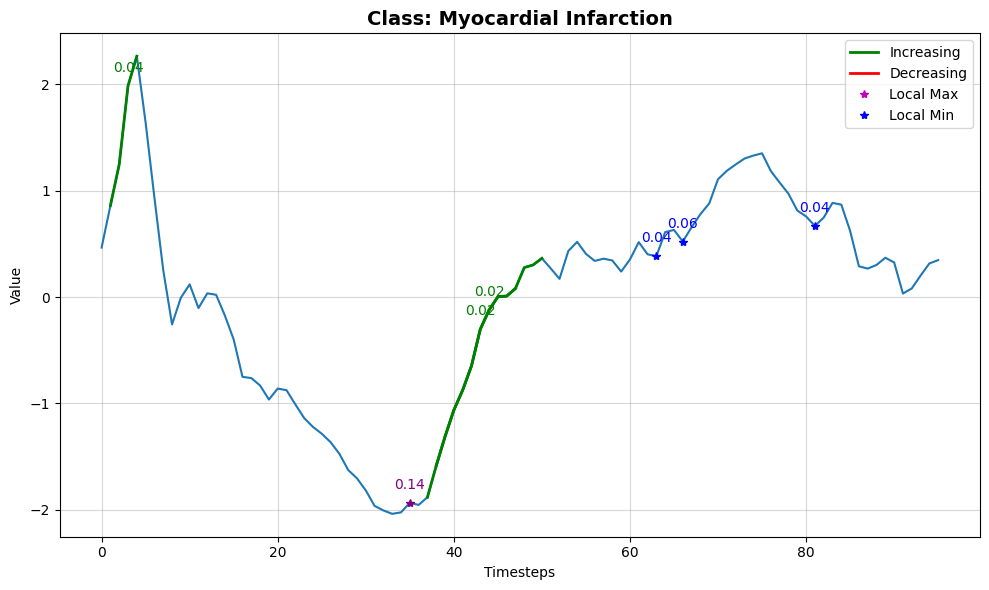

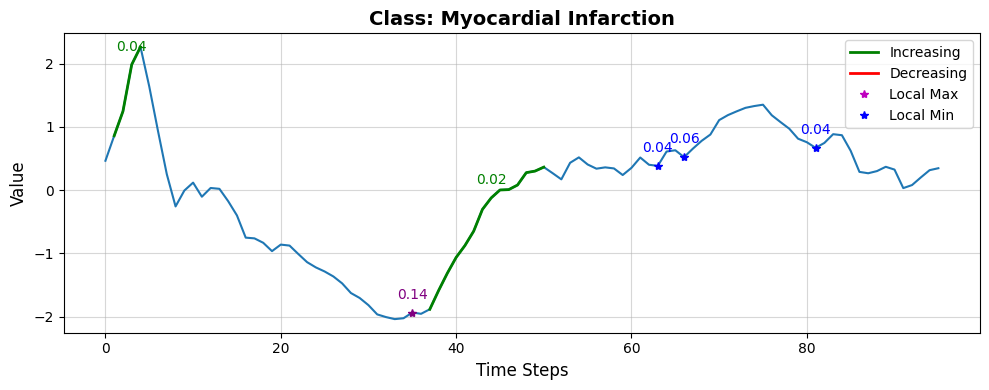

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.6234, 0.3766])
Myocardial Infarction:                      0.6234
Normal Heartbeat:                      0.3766


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 76) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 76


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.86
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.79
INFO:lomatce.explainer:Model Type: Ridge


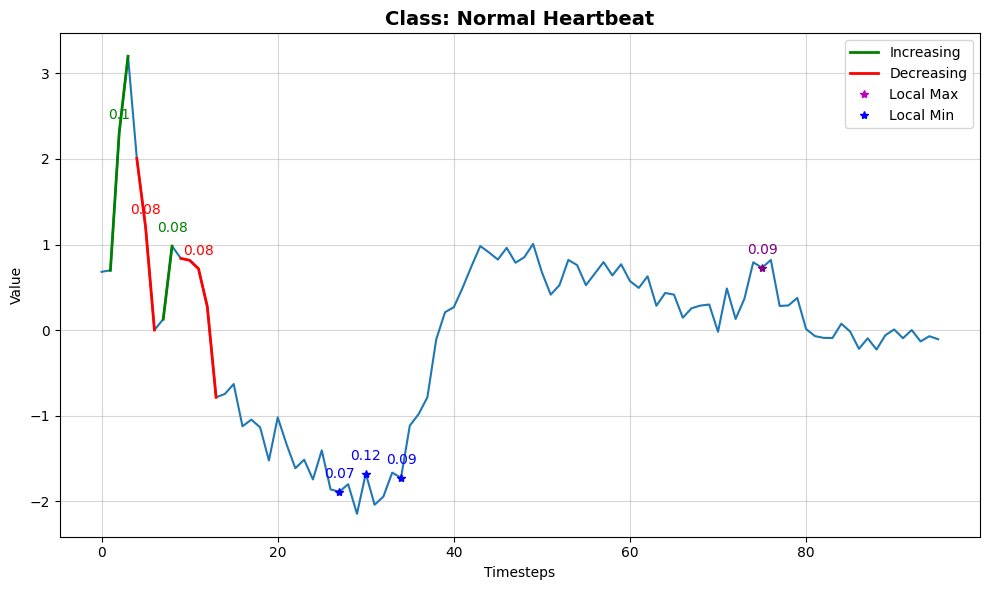

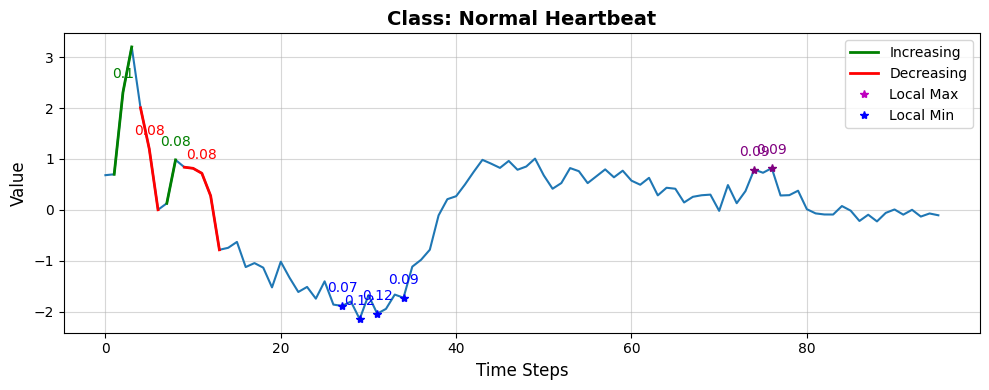

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.2307, 0.7693])
Myocardial Infarction:                      0.2307
Normal Heartbeat:                      0.7693


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 76) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 76


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.92
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.91
INFO:lomatce.explainer:Model Type: Ridge


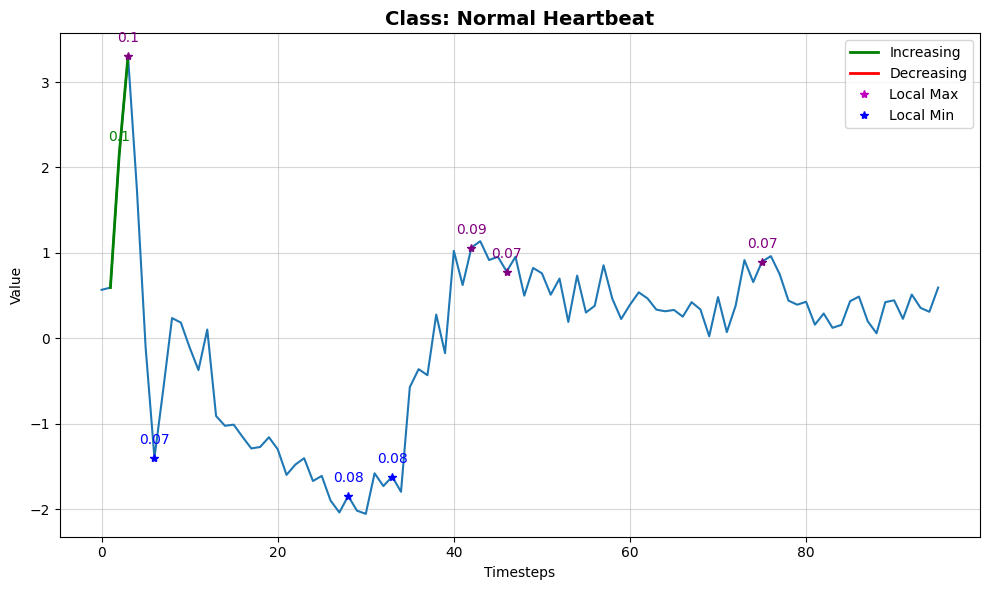

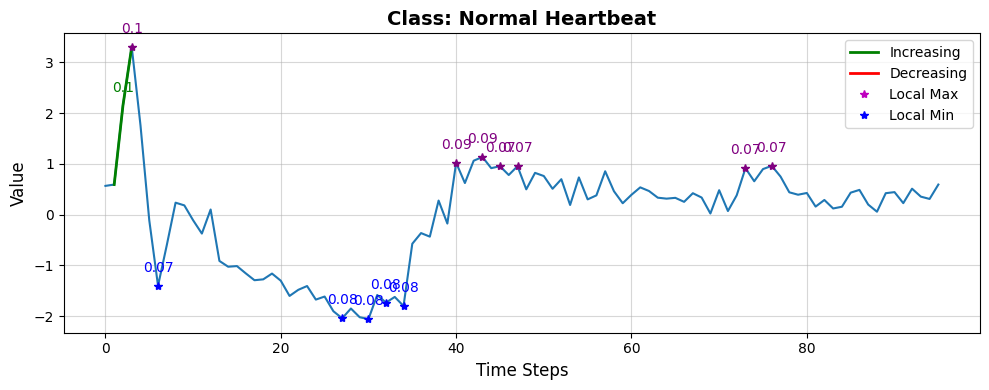

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.1115, 0.8885])
Myocardial Infarction:                      0.1115
Normal Heartbeat:                      0.8885
Replacement methods: total_mean


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 17 = 17
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 74) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 74


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.64
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.66
INFO:lomatce.explainer:Model Type: Ridge


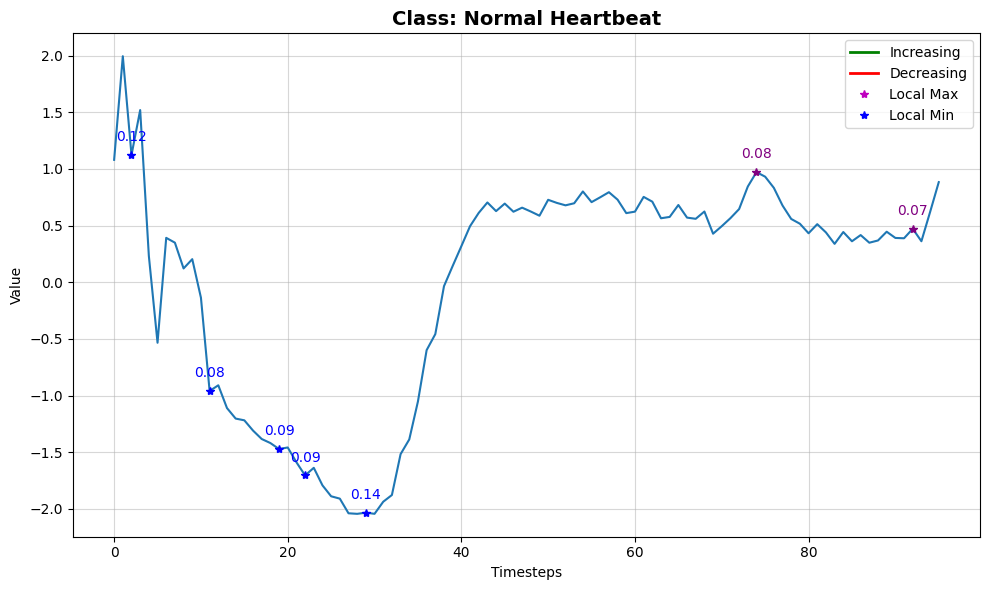

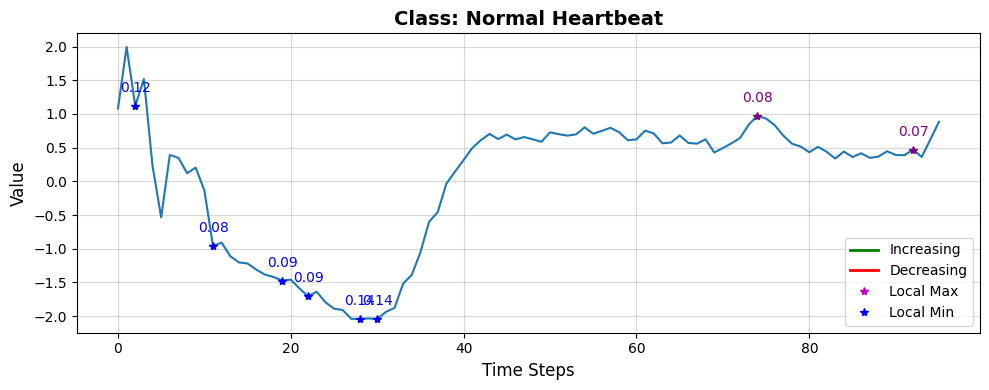

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.3287, 0.6713])
Myocardial Infarction:                      0.3287
Normal Heartbeat:                      0.6713


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 16 = 16
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 18 = 18
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 72) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 72


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.93
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.61
INFO:lomatce.explainer:Model Type: Ridge


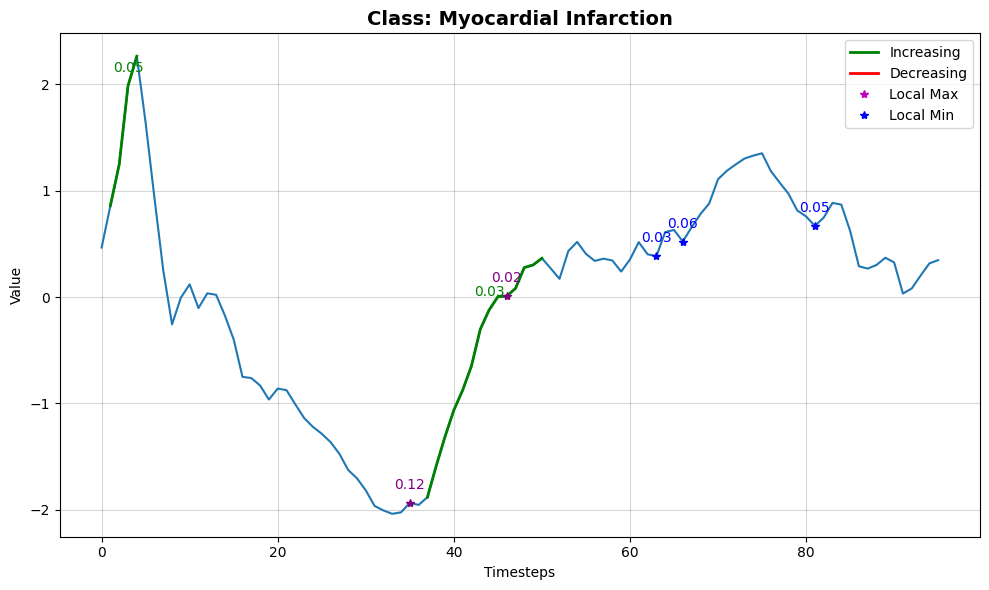

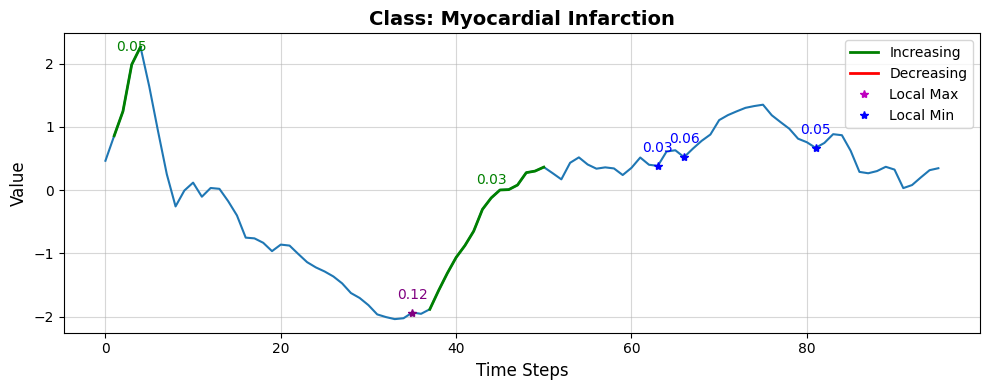

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.6234, 0.3766])
Myocardial Infarction:                      0.6234
Normal Heartbeat:                      0.3766


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 76) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 76


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.93
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.8
INFO:lomatce.explainer:Model Type: Ridge


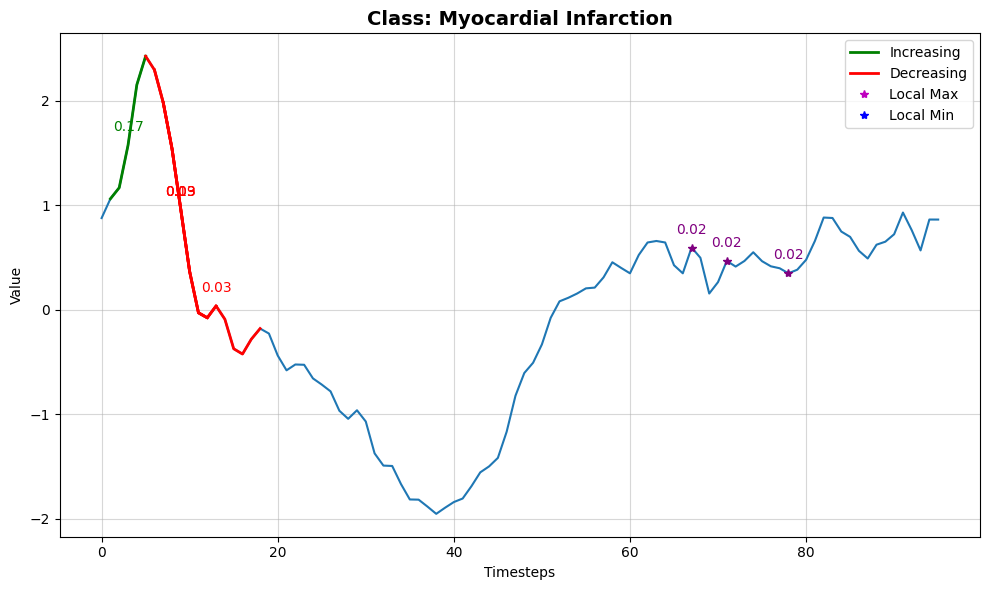

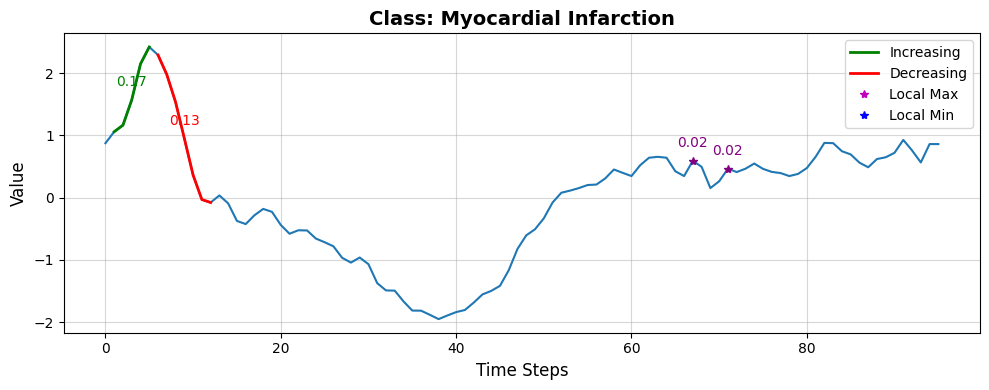

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.8456, 0.1544])
Myocardial Infarction:                      0.8456
Normal Heartbeat:                      0.1544


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 18 = 18
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 18 = 18


INFO:lomatce.explainer:Final data shape: (1001, 74) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 74


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.9
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.87
INFO:lomatce.explainer:Model Type: Ridge


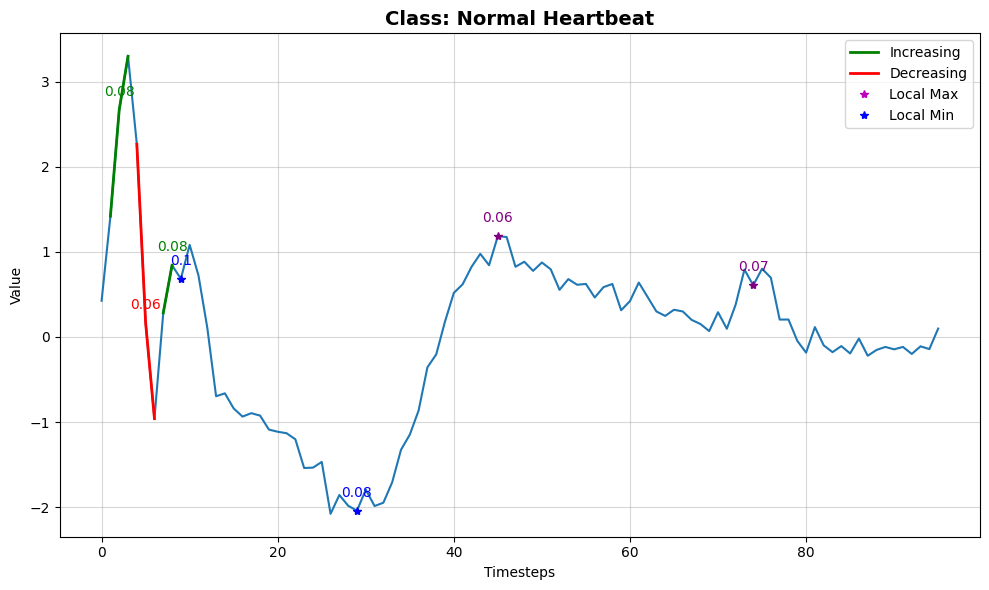

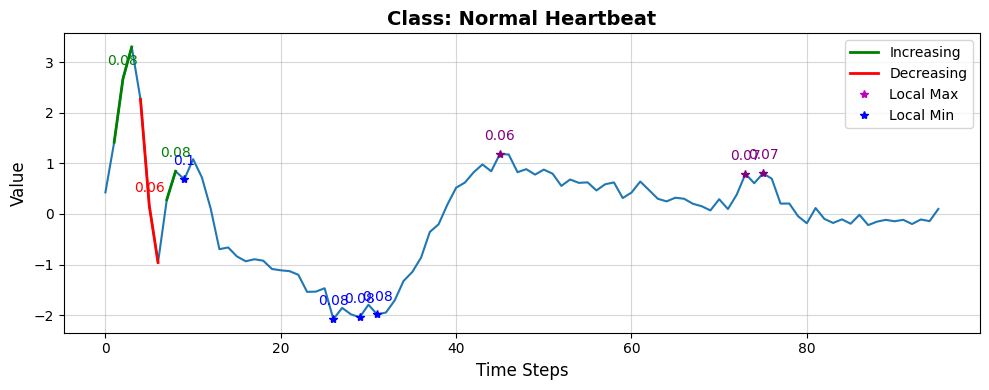

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.1596, 0.8404])
Myocardial Infarction:                      0.1596
Normal Heartbeat:                      0.8404


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 18 = 18
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 75) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 75


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.88
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.54
INFO:lomatce.explainer:Model Type: Ridge


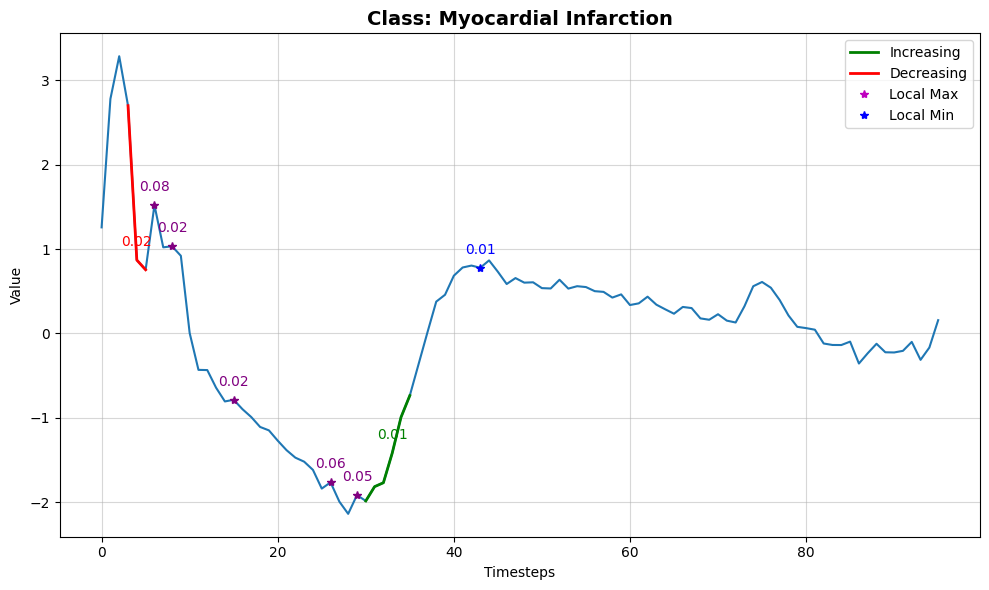

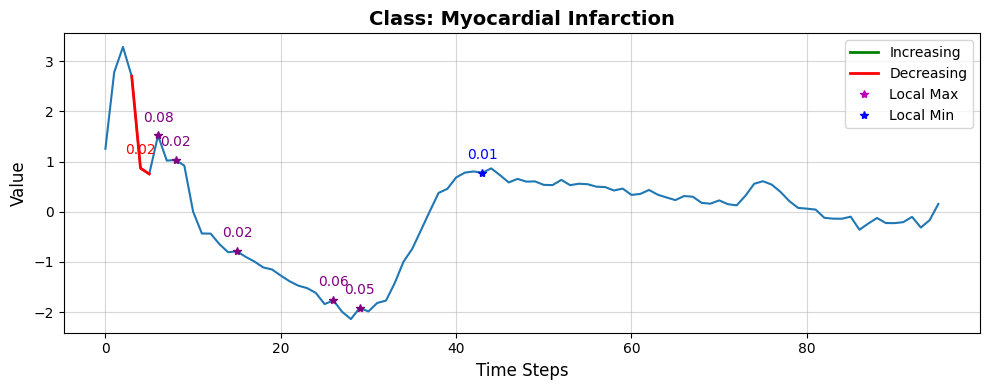

Predection probability : tensor([0.5666, 0.4334])
Myocardial Infarction:                      0.5666
Normal Heartbeat:                      0.4334


In [33]:
# Define the replacement methods
replacement_methods = ['zero', 'total_mean']

# Initialize a dictionary to store the results
results = {}

# Iterate over the replacement methods
for method in replacement_methods:
    # Initialize a list to store prediction scores for the current method
    print(f'Replacement methods: {method}')
    prediction_scores = []
    
    # Run the function 100 times for the current method
    for _ in range(5):
        # Randomly select an instance
        origi_instance_1 = X_test[np.random.randint(len(X_test))]

        # Call the ts_local_explanation function with the current replacement method
        explanation = lomatce_explainer.explain_instance(origi_instance_1, lambda data : predict_fn(data, learn_new), num_perturbations=1000, class_names=class_labels, replacement_method=method)
        
        # Append the prediction score to the list
        # prediction_scores.append(prediction_score)
    
    # Compute the mean and standard deviation of the prediction scores for the current method
#     mean_prediction_score = np.mean(prediction_scores)
#     std_prediction_score = np.std(prediction_scores)
    
#     # Store the results in the dictionary
#     results[method] = (mean_prediction_score, std_prediction_score)

# # Print the results in tabular format
# print("Replacement Method\tAverage Prediction Score\tStandard Deviation")
# for method, (mean_score, std_score) in results.items():
#     print(f"{method}\t\t\t{mean_score:.2f}  \u00B1 {std_score:.2f}")


### Integrated Gradient

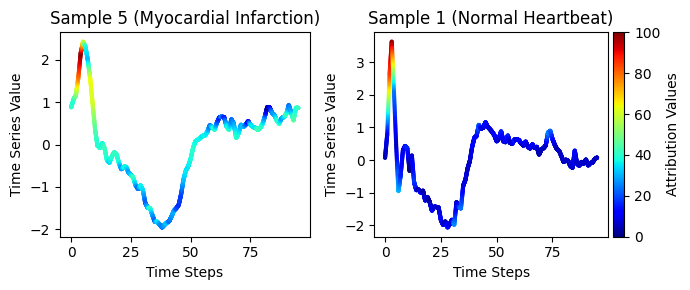

In [20]:
import torch
import numpy as np
from torch import tensor
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define a function to compute Integrated Gradients
def compute_integrated_gradients(x, target):
    integrated_gradients = IntegratedGradients(learn_new.model.cpu())
    attr, delta = integrated_gradients.attribute(x, target=target, return_convergence_delta=True)
    return attr.squeeze().cpu().numpy()

# Function to plot Integrated Gradients
def plot_integrated_gradients(x_sample, target, ax):
    # Compute Integrated Gradients for the sample
    attributions = compute_integrated_gradients(x_sample, target)

    max_length = 3000  # Adjust as needed

    time_steps = torch.arange(len(x_sample.reshape(-1,1)))  # Generate time step indices
    minimum = np.min(attributions)

    attributions = attributions - minimum
    attributions = attributions / max(attributions)
    attributions = attributions * 100

    x = np.linspace(0, x_sample.shape[2] - 1, max_length, endpoint=True)

    # Interpolate the time series values
    f_ts = interp1d(range(x_sample.shape[2]), x_sample[0, 0, :])
    y_ts = f_ts(x)

    # Interpolate the attribution values
    f_cas = interp1d(range(len(attributions)), attributions)
    cas_interpolated = f_cas(x).astype(int)

    # Plot the interpolated attribution values against the interpolated time series
    scatter = ax.scatter(x=x, y=y_ts, c=cas_interpolated, cmap='jet', marker='.', vmin=0, vmax=100, linewidths=0.0)
    return scatter

# Select two samples from the test set for visualization
sample_indices = [5, 1 ]
targets = [0, 1]  # Specify the target for each sample
x_samples = [tensor(X_test[sample_idx][None]) for sample_idx in sample_indices]

# Create subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
labels = class_labels

# Plot Integrated Gradients for each sample
for i, (x_sample, target, ax) in enumerate(zip(x_samples, targets, axs)):
    scatter = plot_integrated_gradients(x_sample, target, ax)
    ax.set_title(f'Sample {sample_indices[i]} ({labels[target]})')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Time Series Value')

# Create a new axis on the right side of the last subplot for the color bar
divider = make_axes_locatable(axs[-1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(scatter, cax=cax)
cbar.set_label('Attribution Values')

plt.tight_layout()
plt.show()


### LIME


🔍 Explaining instance 0 — Predicted class: Normal Heartbeat


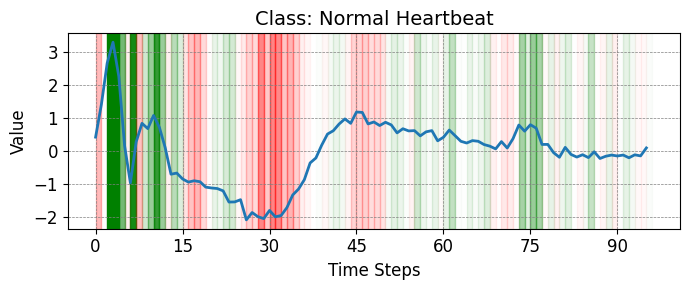


🔍 Explaining instance 1 — Predicted class: Normal Heartbeat


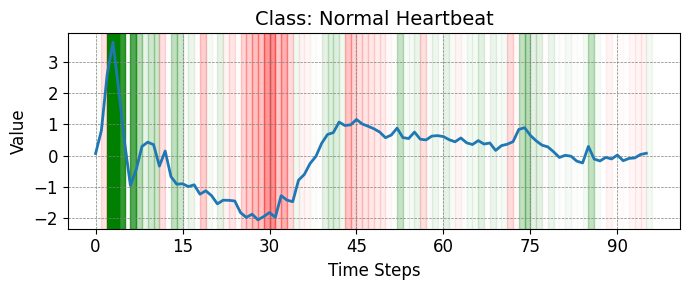


🔍 Explaining instance 2 — Predicted class: Normal Heartbeat


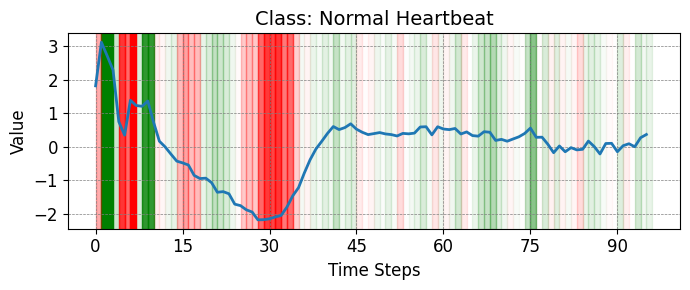


🔍 Explaining instance 3 — Predicted class: Normal Heartbeat


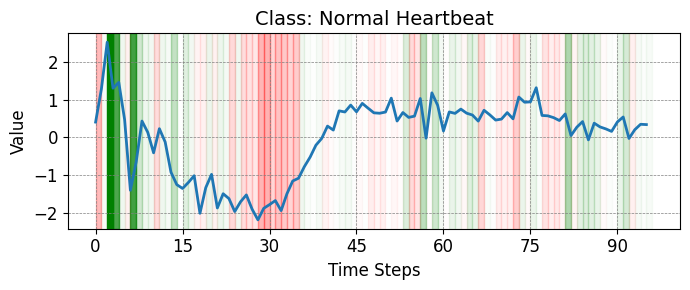


🔍 Explaining instance 4 — Predicted class: Myocardial Infarction


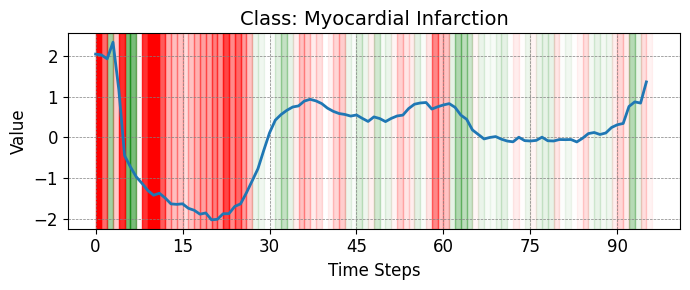

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import math
from lomatce.lime_timeseries import LimeTimeSeriesExplainer
import logging
logging.getLogger().setLevel(logging.WARNING) 

# Predict function that LIME will use
def predict_fn(data):
    if len(data.shape) == 2:
        data = data.reshape(data.shape[0], 1, data.shape[1])  # Handle univariate case
    data_dl = test_loader.test_dataloader(learn_new, data)
    data_probas, _, _ = learn_new.get_preds(dl=data_dl, with_decoded=True, save_preds=None)
    return data_probas.numpy()

# Compute LIME and visualize importance
def compute_lime_importances(flat_series, predict_fn, num_slices=25, num_features=10, num_samples=5000, class_label=None, class_names=None):
    if num_slices is None:
        num_slices = len(flat_series)
    explainer = LimeTimeSeriesExplainer(class_names=class_names)

    exp = explainer.explain_instance(
        flat_series,
        predict_fn,
        num_features=num_features,
        num_samples=num_samples,
        num_slices=num_slices,
        replacement_method='total_mean'
    )

    values_per_slice = math.ceil(len(flat_series) / num_slices)
    segments_weights = exp.as_list()
    sorted_segments = sorted(segments_weights, key=lambda x: x[1], reverse=True)

    # Plot
    plt.figure(figsize=(7, 3))
    plt.plot(flat_series, color='C0', linewidth=2)

    for feature, weight in sorted_segments:
        start = feature * values_per_slice
        end = min(start + values_per_slice, len(flat_series))
        color = 'red' if weight < 0 else 'green'
        alpha = min(abs(weight) * 20, 1.0)
        plt.axvspan(start, end, color=color, alpha=alpha, edgecolor='none')

    plt.title(f'Class: {class_label}', fontsize=14)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

    return sorted_segments

# 🔁 Explain multiple instances
num_instances_to_explain = 5  # Change to 6 or more if desired
for idx in range(num_instances_to_explain):
    label_index = int(test_preds[idx])  # Convert '0' or '1' string to int
    class_label = class_labels[label_index]

    instance = X_test[idx]  # Shape: (channels, time)
    flat_series = instance.flatten() if instance.ndim == 2 else instance  # Flatten if 2D

    print(f"\n🔍 Explaining instance {idx} — Predicted class: {class_label}")
    compute_lime_importances(
        flat_series,
        predict_fn,
        num_slices=96,
        num_features=96,
        num_samples=5000,
        class_label=class_label,
        class_names=class_labels
    )


### SHAP


🔍 Explaining instance 0 — Predicted class: Normal Heartbeat


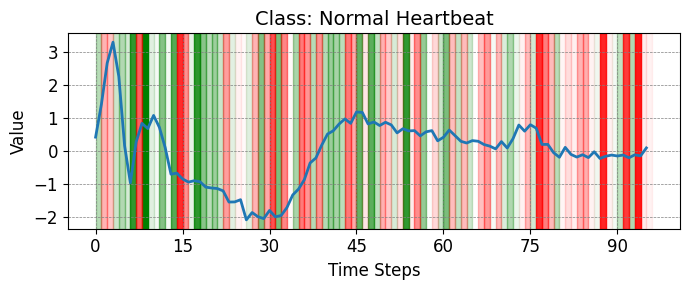


🔍 Explaining instance 1 — Predicted class: Normal Heartbeat


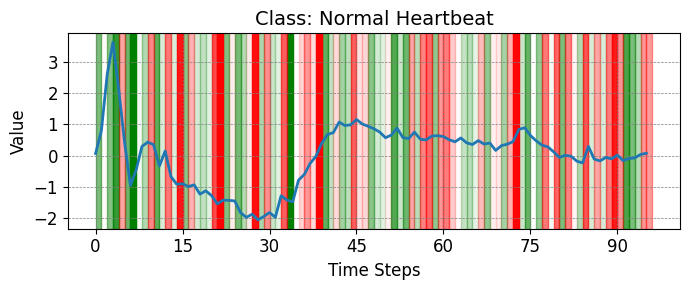


🔍 Explaining instance 2 — Predicted class: Normal Heartbeat


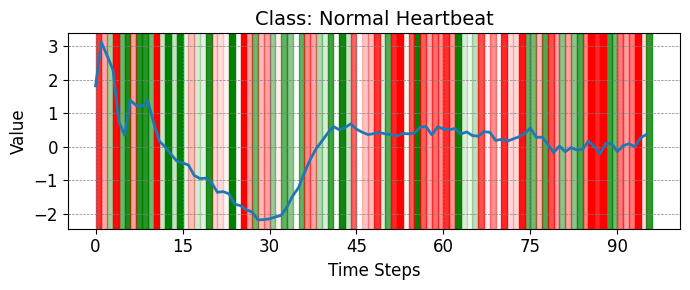


🔍 Explaining instance 3 — Predicted class: Normal Heartbeat


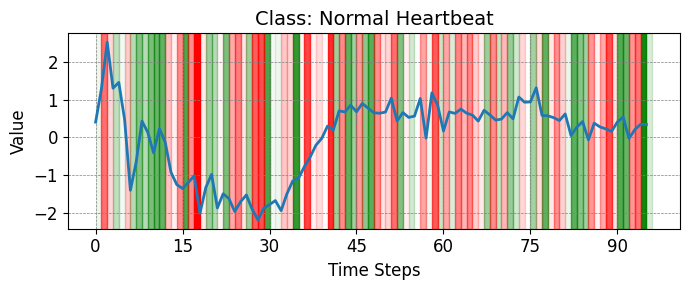


🔍 Explaining instance 4 — Predicted class: Myocardial Infarction


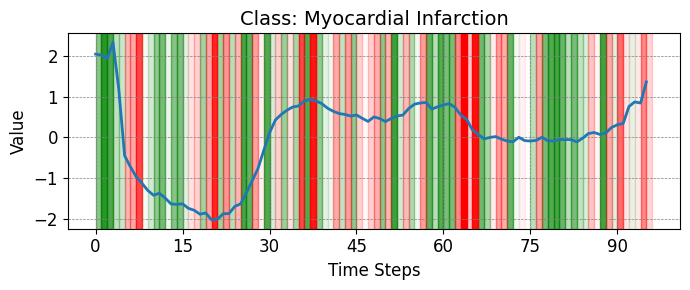

In [24]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import math

# --- 1. Segmenting Function ---
def create_segments(X, num_segments=None):
    num_samples, num_channels, sequence_length = X.shape
    if num_segments is None:
        num_segments = sequence_length
    segment_length = sequence_length // num_segments
    return num_segments, segment_length

# --- 2. Predict Function for SHAP ---
def predict_fn(masks, instance, background_data, num_segments, segment_length, learner):
    masked_inputs = []
    for mask in masks:
        masked_instance = instance.copy()
        for seg_idx in range(num_segments):
            start = seg_idx * segment_length
            end = (seg_idx + 1) * segment_length
            if mask[seg_idx] == 0:
                random_idx = np.random.randint(0, background_data.shape[0])
                background_segment = background_data[random_idx, :, start:end]
                masked_instance[0, :, start:end] = background_segment
        masked_inputs.append(masked_instance[0])
    masked_inputs = np.stack(masked_inputs)  # (num_masks, channels, time)
    data_dl = test_loader.test_dataloader(learner, masked_inputs)
    data_probas, _, _ = learner.get_preds(dl=data_dl, with_decoded=True, save_preds=None)
    return data_probas.numpy()

# --- 3. Plotting SHAP Segment Importance ---
def plot_segment_importance(flat_series, shap_values, segment_length, class_name):
    num_segments = len(shap_values)
    flat_series = flat_series.flatten() if len(flat_series.shape) == 2 else flat_series
    values_per_slice = math.ceil(len(flat_series) / segment_length)
    sorted_segments = sorted(enumerate(shap_values), key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(7, 3))
    plt.plot(flat_series, color='C0', linewidth=2)
    
    for segment_idx, weight in sorted_segments:
        start = segment_idx * values_per_slice
        end = min(start + values_per_slice, len(flat_series))
        color = 'red' if weight < 0 else 'green'
        alpha = min(abs(weight) * 10, 1.0)
        plt.axvspan(start, end, color=color, alpha=alpha, edgecolor='none')

    plt.title(f'Class: {class_name}', fontsize=14)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

# --- 4. SHAP Explanation for Multiple Instances ---
# Set number of segments
num_segments, segment_length = create_segments(X_train, num_segments=None)

# Sample background for masking
background_data = X_train[np.random.choice(len(X_train), min(100, len(X_train)), replace=False)]

# Loop over multiple test instances
num_instances_to_explain = 5

for idx in range(num_instances_to_explain):
    instance_to_explain = X_test[idx:idx+1]  # Shape: (1, C, T)
    label_index = int(test_preds[idx])
    class_name = class_labels[label_index]
    print(f"\n🔍 Explaining instance {idx} — Predicted class: {class_name}")
    # SHAP explainer setup
    predict_fn_shap = lambda masks: predict_fn(
        masks,
        instance=instance_to_explain,
        background_data=background_data,
        num_segments=num_segments,
        segment_length=segment_length,
        learner=learn_new
    )

    explainer = shap.Explainer(predict_fn_shap, np.zeros((1, num_segments)))
    shap_values = explainer.shap_values(np.ones((1, num_segments)))
    
    # Extract SHAP values for the predicted class
    if isinstance(shap_values, list):
        shap_value = shap_values[label_index][0]
    else:
        shap_value = shap_values[0, :, label_index]

    shap_values_flat = np.array(shap_value).flatten()
    sorted_indices = np.argsort(-np.abs(shap_values_flat))
    sorted_shap_values = shap_values_flat[sorted_indices]
    important_time_steps = sorted_indices

    # Plot the explanation
    flat_series = instance_to_explain.reshape(1, instance_to_explain.shape[2])
    plot_segment_importance(flat_series, shap_values_flat, num_segments, class_name)


### SP-LOMATCE

In [15]:
from lomatce.sp_lomatce import SPLomatce


In [16]:
# Function for select balanced instances
def select_instances_balanced(X, y, n_per_class):
    selected_indices = []
    classes = np.unique(y)

    for cls in classes:
        cls_indices = np.where(y == cls)[0]
        chosen = np.random.choice(cls_indices, min(n_per_class, len(cls_indices)), replace=False)
        selected_indices.extend(chosen)

    return selected_indices

In [19]:
# Step 1: Choose subset of instances (balanced or global)
n_per_class = 5  # example
selected_indices = []
classes = np.unique(y_test)
for cls in classes:
    cls_indices = np.where(y_test == cls)[0]
    chosen = np.random.choice(cls_indices, min(n_per_class, len(cls_indices)), replace=False)
    selected_indices.extend(chosen)

print("Selected subset indices for LOMATCE:", selected_indices)

Selected subset indices for LOMATCE: [4, 21, 36, 24, 5, 16, 46, 0, 18, 6]


INFO:lomatce.explainer:Starting time series local explanation
INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 17 = 17
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 17 = 17
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 72) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 72


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.9
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.85
INFO:lomatce.explainer:Model Type: Ridge


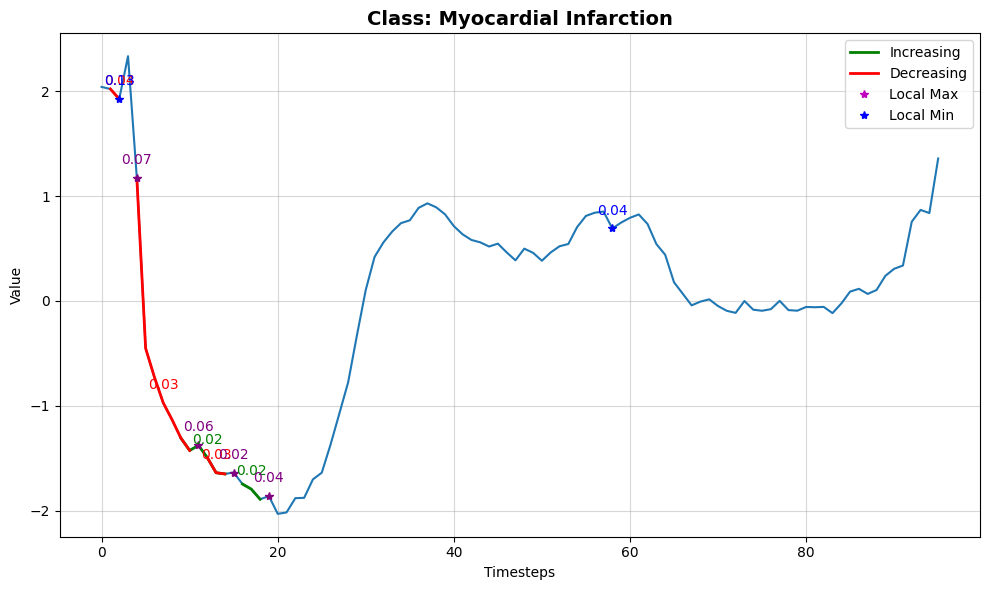

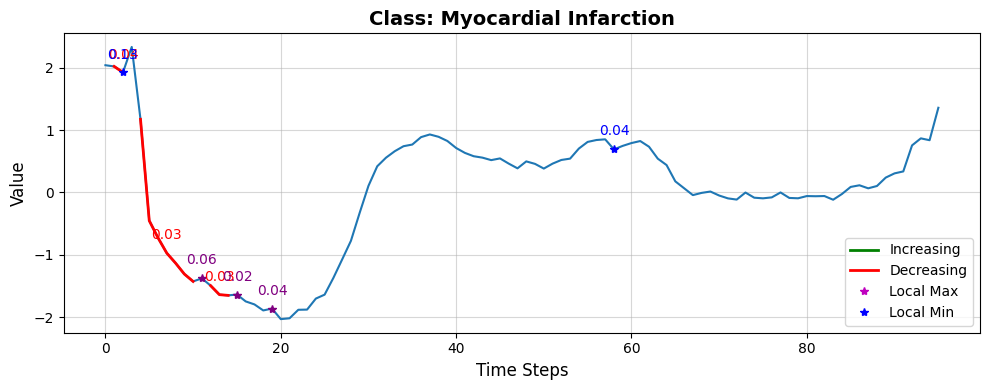

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.8476, 0.1524])
Myocardial Infarction:                      0.8476
Normal Heartbeat:                      0.1524


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 76) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 76


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.94
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.83
INFO:lomatce.explainer:Model Type: Ridge


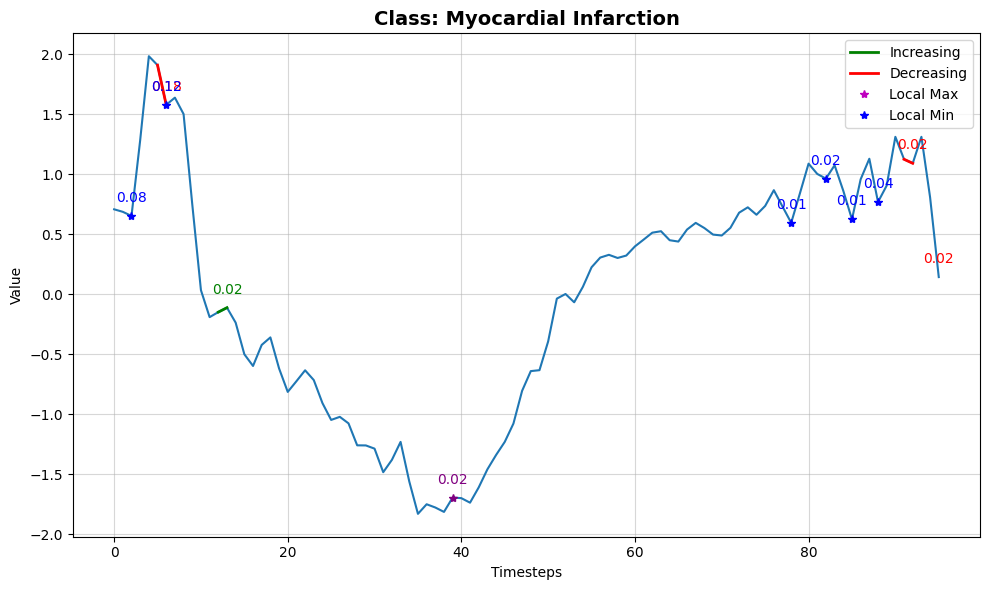

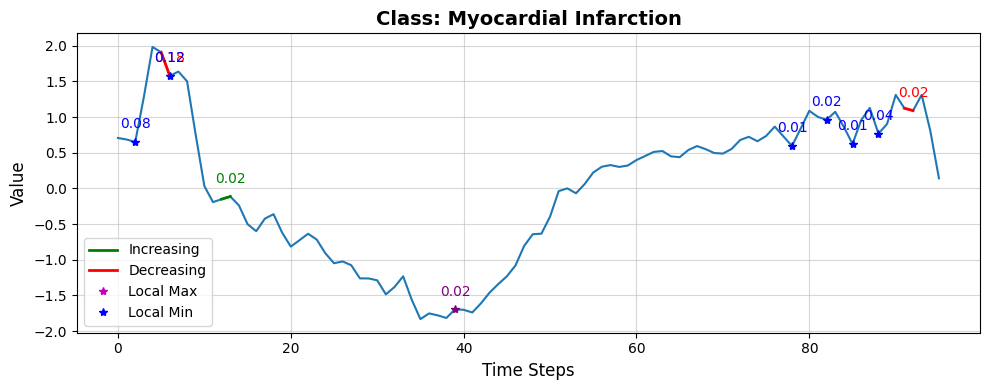

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.8606, 0.1394])
Myocardial Infarction:                      0.8606
Normal Heartbeat:                      0.1394


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 17 = 17
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 74) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 74


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.94
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.85
INFO:lomatce.explainer:Model Type: Ridge


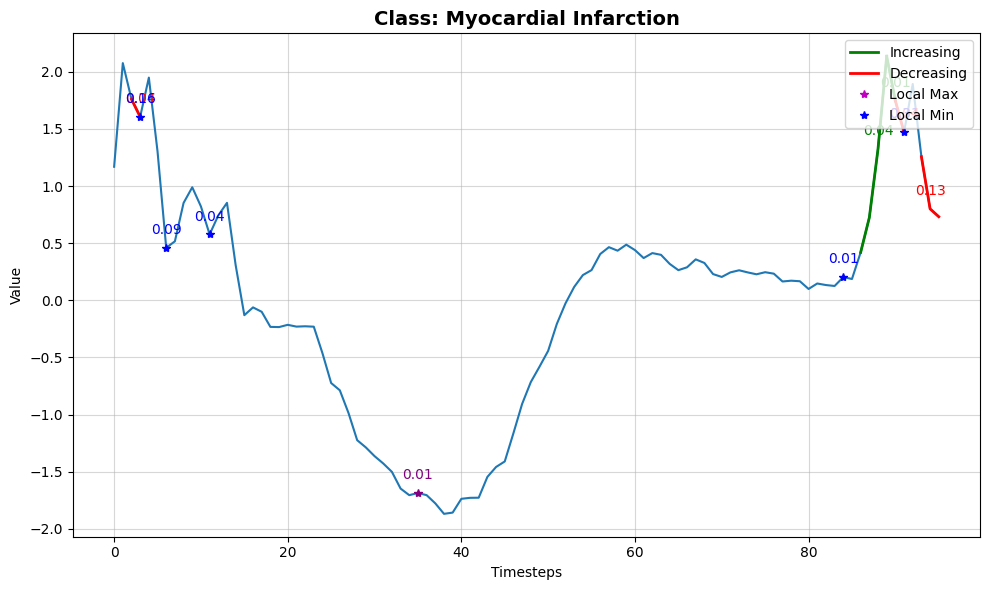

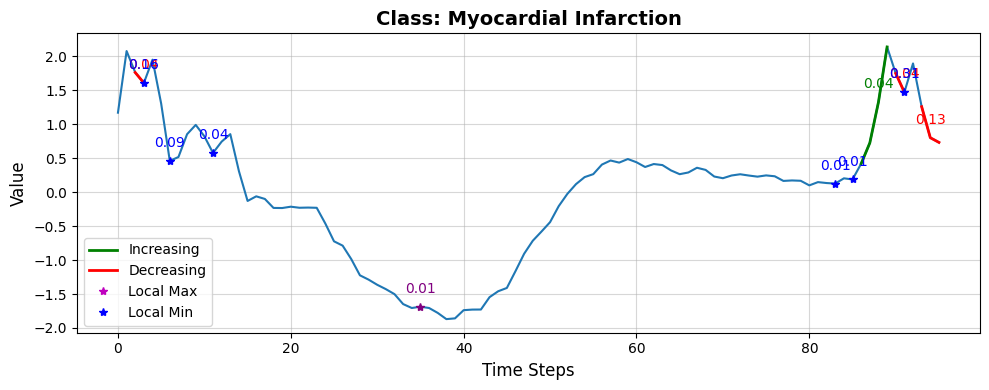

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.8645, 0.1355])
Myocardial Infarction:                      0.8645
Normal Heartbeat:                      0.1355


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 76) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 76


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.64
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.52
INFO:lomatce.explainer:Model Type: Ridge


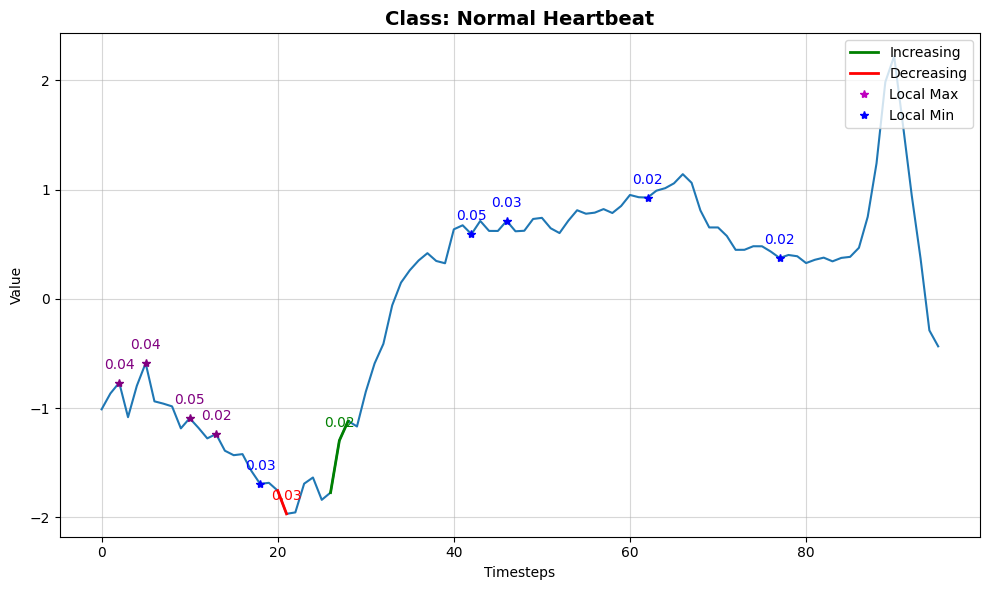

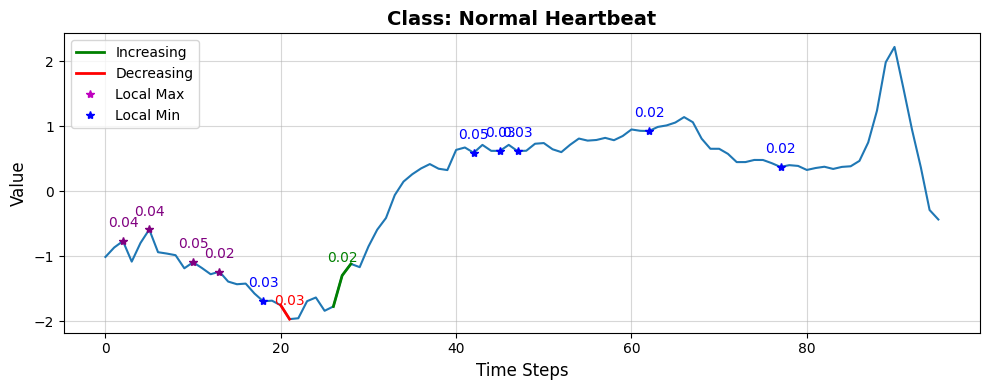

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.4967, 0.5033])
Myocardial Infarction:                      0.4967
Normal Heartbeat:                      0.5033


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 76) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 76


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.94
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.85
INFO:lomatce.explainer:Model Type: Ridge


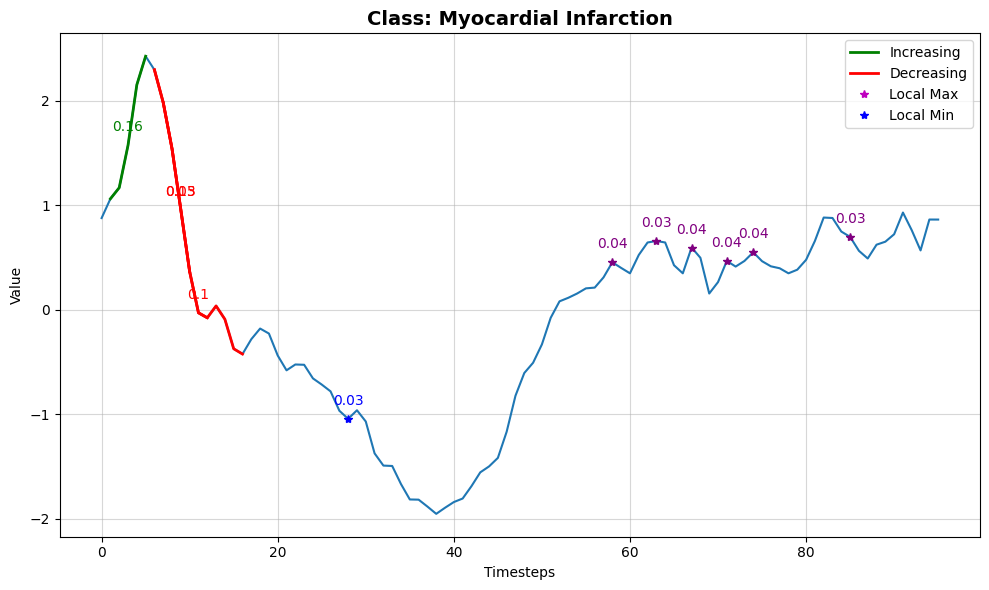

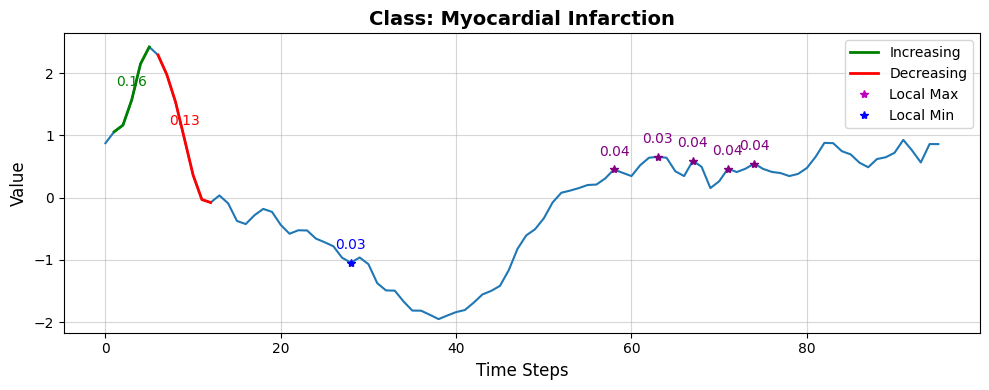

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.9014, 0.0986])
Myocardial Infarction:                      0.9014
Normal Heartbeat:                      0.0986


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 17 = 17
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 17 = 17


INFO:lomatce.explainer:Final data shape: (1001, 72) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 72


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.89
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.57
INFO:lomatce.explainer:Model Type: Ridge


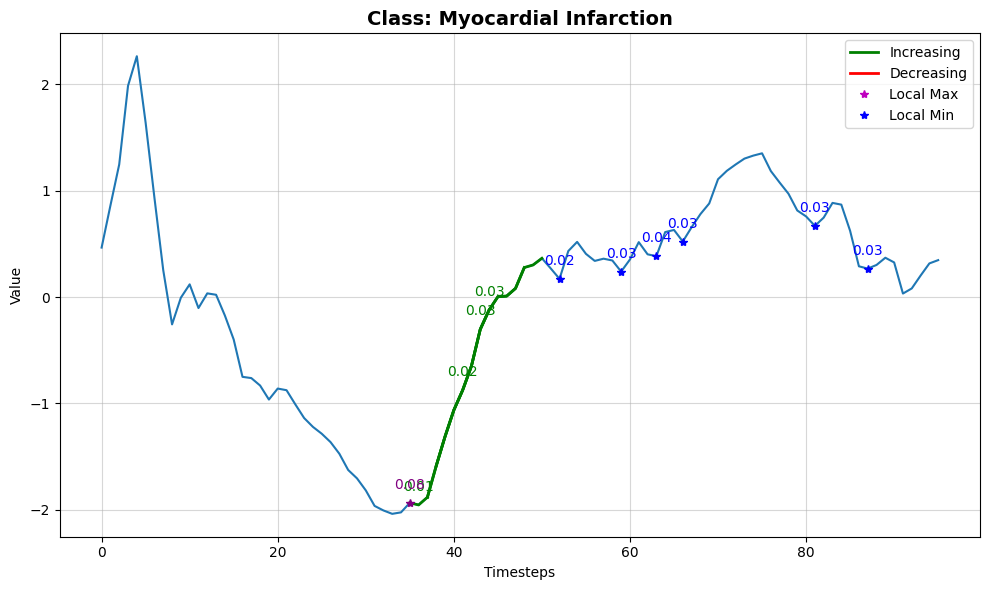

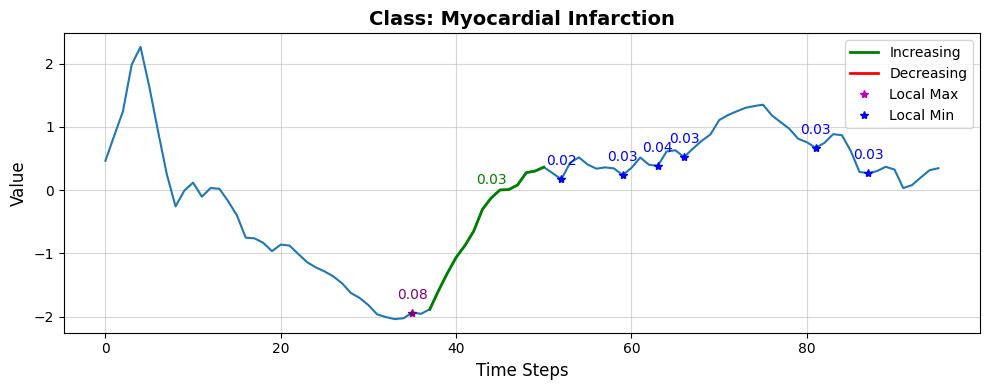

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.5734, 0.4266])
Myocardial Infarction:                      0.5734
Normal Heartbeat:                      0.4266


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 18 = 18
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 18 = 18
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 74) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 74


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.88
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.58
INFO:lomatce.explainer:Model Type: Ridge


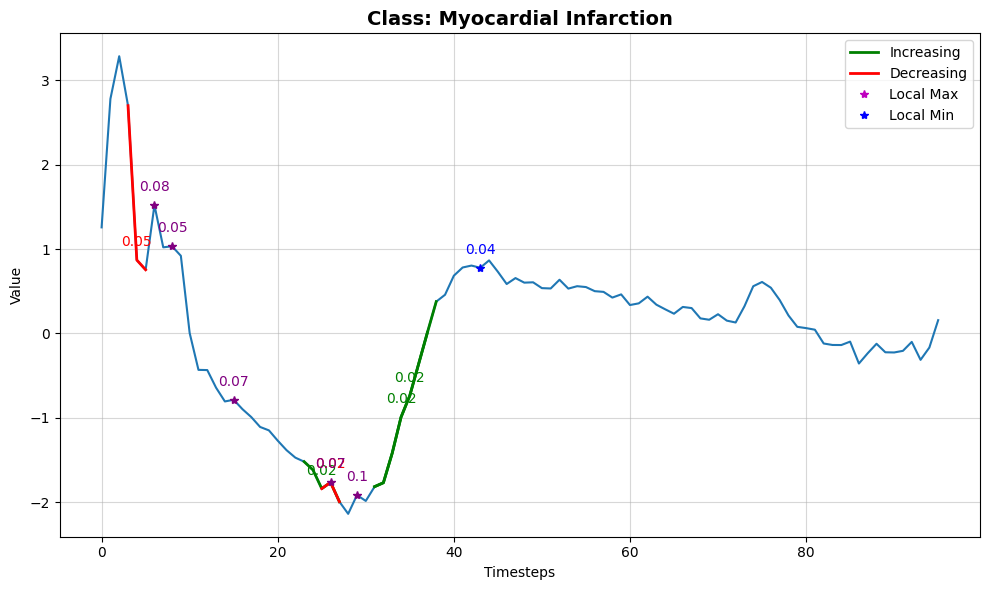

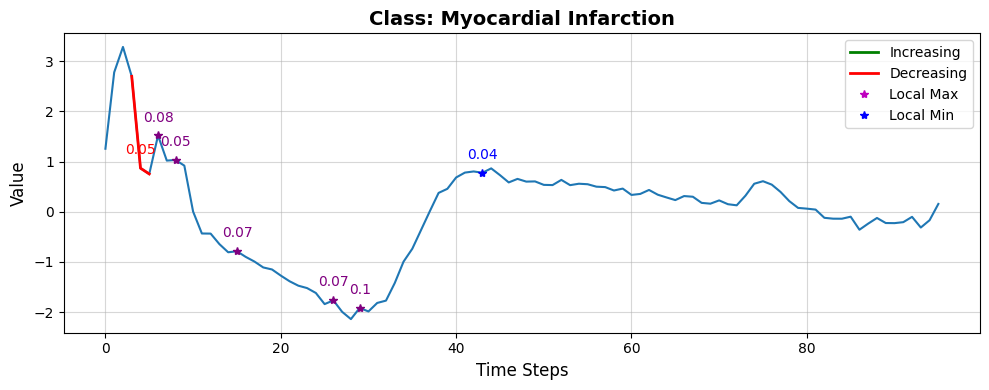

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.5979, 0.4021])
Myocardial Infarction:                      0.5979
Normal Heartbeat:                      0.4021


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 17 = 17
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 18 = 18


INFO:lomatce.explainer:Final data shape: (1001, 73) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 73


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.87
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.87
INFO:lomatce.explainer:Model Type: Ridge


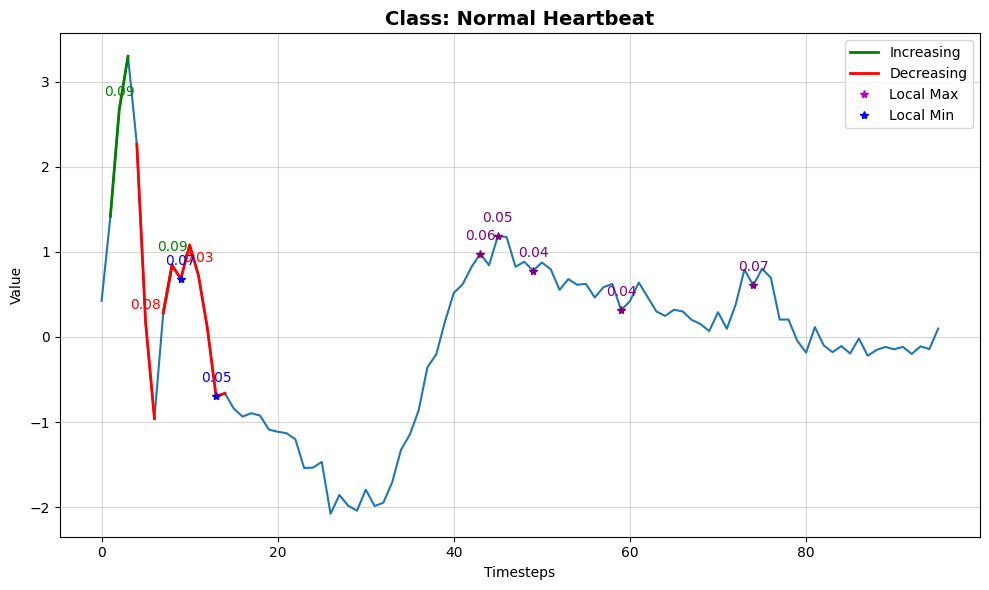

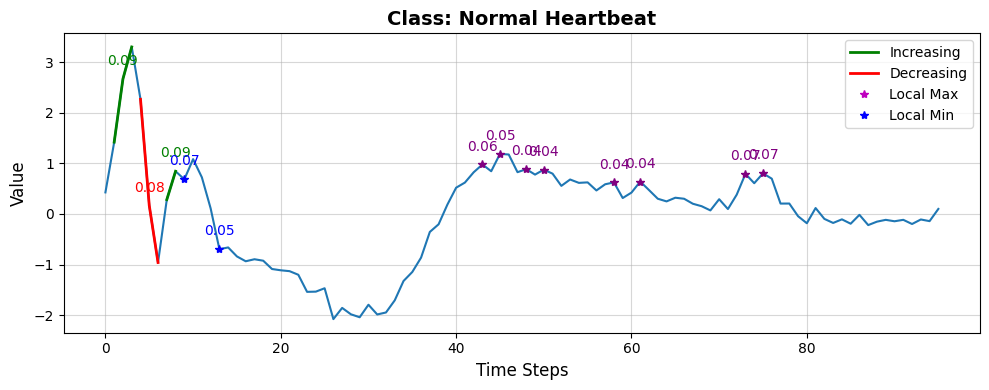

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.1344, 0.8656])
Myocardial Infarction:                      0.1344
Normal Heartbeat:                      0.8656


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 18 = 18


INFO:lomatce.explainer:Final data shape: (1001, 75) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 75


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.91
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.87
INFO:lomatce.explainer:Model Type: Ridge


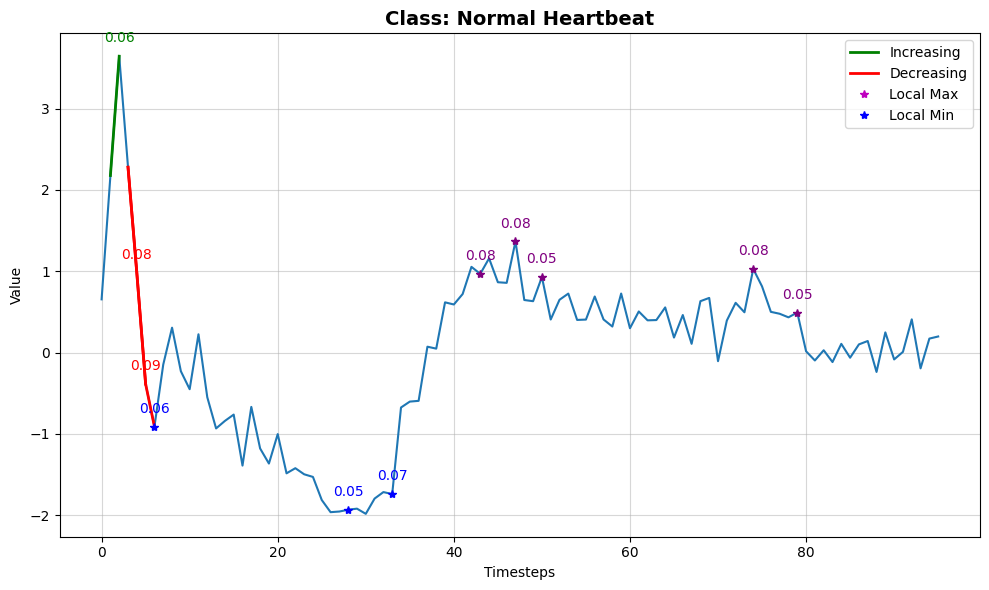

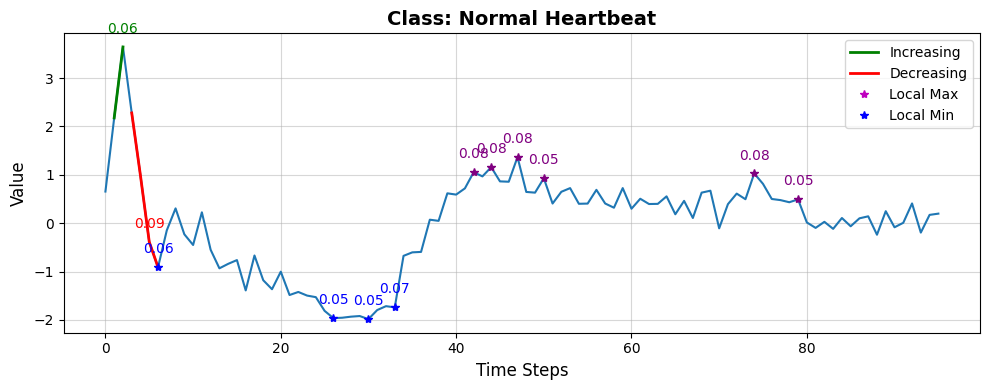

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.1299, 0.8701])
Myocardial Infarction:                      0.1299
Normal Heartbeat:                      0.8701


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 13 = 13
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 18 = 18
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 69) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 69


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.54
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.62
INFO:lomatce.explainer:Model Type: Ridge


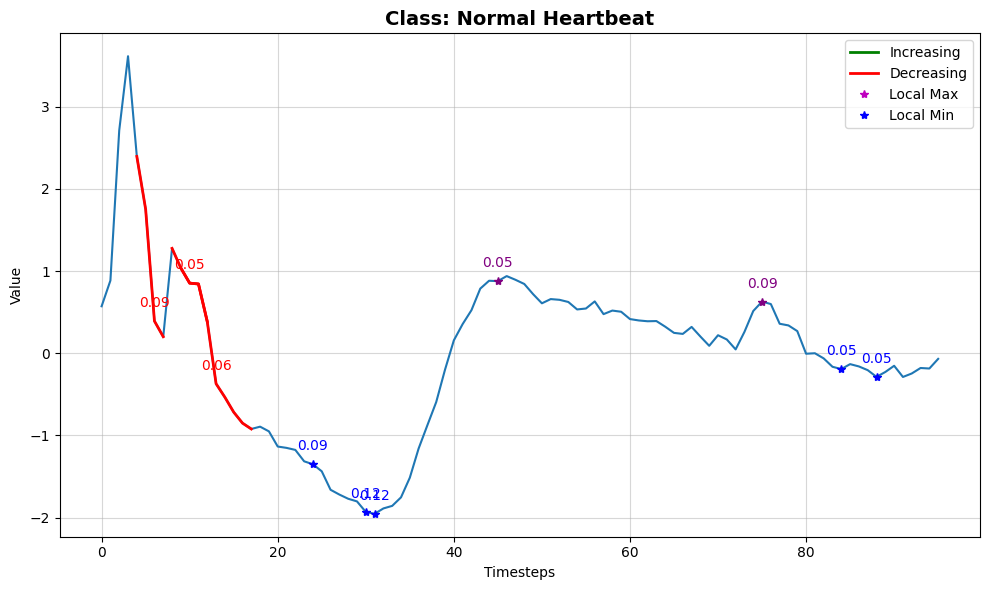

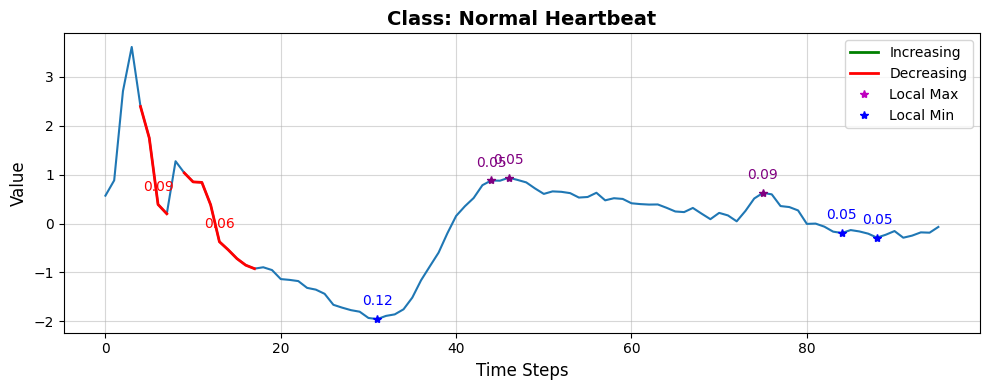

Predection probability : tensor([0.3501, 0.6499])
Myocardial Infarction:                      0.3501
Normal Heartbeat:                      0.6499
Generated 10 explanations.


In [20]:
# Step 2: Generate LOMATCE explanations
explanations = []
for idx in selected_indices:
    instance = X_test[idx]
    explanation = lomatce_explainer.explain_instance(
        instance, 
        lambda data: predict_fn(data, learn_new), 
        num_perturbations=1000, 
        class_names=class_labels, 
        replacement_method='zero',
        top_n=15,
    )
    explanations.append(explanation)

print(f"Generated {len(explanations)} explanations.")

In [ ]:
# Initialize SP-LOMATCE
sp = SPLomatce(explanations, B=8, per_class=False)

# Merge clusters & build instance-cluster matrix
sp.merge_clusters()  # adjust threshold as needed
W, global_clusters = sp.build_instance_cluster_matrix()

# Compute global cluster importance
I = sp.compute_global_cluster_importance(W)

# Select instances via submodular pick
selected_indices = sp.submodular_pick(W, I, B=8)

# Retrieve events for the selected instances
selected_events = sp.get_selected_events(selected_indices)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (448,) + inhomogeneous part.

In [21]:
import numpy as np
from collections import defaultdict
from scipy.cluster.hierarchy import linkage, fcluster

def merge_clusters_by_event_type(explanations, percentile=75, method='average', top_n=None):
    """
    Merge similar local clusters into global clusters, separately for each event type.
    Handles different centroid dimensionalities and multiple instances.
    
    Parameters:
    - explanations: list of explanation objects with `cluster_centroids` dict
    - percentile: percentile of linkage distances to set automatic threshold
    - method: linkage method ('single', 'complete', 'average', 'ward')
    
    Returns:
    - merged_cluster_map: dict mapping local-instance cluster → global cluster
    - global_clusters_by_type: dict of event_type → list of global clusters
    """
    merged_cluster_map = {}
    global_clusters_by_type = {}

    # Step 1: Organize centroids by event type
    centroids_by_type = defaultdict(list)
    local_keys_by_type = defaultdict(list)
   

    for inst_idx, exp in enumerate(explanations):
        if not exp.cluster_centroids:
            continue
        if top_n is None:
            top_n = len(exp.important_features)
        # Sort clusters by importance score (descending) and pick top_n
        sorted_top_clusters = sorted(
            exp.cluster_centroids.items(),
            key=lambda kv: exp.important_features.get(kv[0], 0),
            reverse=True
        )[:top_n]
        for local_name, centroid in sorted_top_clusters:
            inst_local_name = f"inst{inst_idx}_{local_name}"
            event_type = local_name.split('_')[0]
            centroids_by_type[event_type].append(centroid)
            local_keys_by_type[event_type].append(inst_local_name)

    # Step 2: Run hierarchical clustering per event type
    for event_type, centroids in centroids_by_type.items():
        if len(centroids) == 0:
            continue

        centroids_array = np.vstack(centroids)  # works even if dim >1

        # Compute linkage matrix
        Z = linkage(centroids_array, method=method)
        # Automatic threshold based on percentile of merge distances
        threshold = np.percentile(Z[:, 2], percentile)
        # Assign cluster labels
        labels = fcluster(Z, t=threshold, criterion='distance')

        # Map local-instance clusters → global clusters
        for local_key, label in zip(local_keys_by_type[event_type], labels):
            global_name = f"Global_{event_type}_{label-1}"  # start from 0
            merged_cluster_map[local_key] = global_name

        # Store unique global clusters per event type
        global_clusters_by_type[event_type] = sorted(set(
            [merged_cluster_map[k] for k in local_keys_by_type[event_type]]
        ))

    return merged_cluster_map, global_clusters_by_type


In [22]:
merge_map, global_clusters = merge_clusters_by_event_type(explanations)

In [23]:
merge_map
# merge_map: local_cluster_name -> global_cluster_name
unique_global_clusters = set(merge_map.values())
print(f"Number of unique global clusters: {len(unique_global_clusters)}")
print(len(merge_map))


Number of unique global clusters: 30
110


In [24]:
explanation_0 = explanations[0]
print(explanation_0.cluster_centroids)
print(explanation_0.important_features)
top_n = len(explanation_0.important_features)
print(top_n)

{'Increasing_ch1_c1': array([87.67439482,  5.99789252,  0.44481246]), 'Increasing_ch1_c2': array([21.05329573, 16.87798055, -0.56406355]), 'Increasing_ch1_c3': array([95.00000213,  0.99999989,  2.19681016]), 'Increasing_ch1_c4': array([48.943926  ,  3.42990651,  0.74900385]), 'Increasing_ch1_c5': array([ 7.55975608e+01,  2.00443451e+00, -7.36479253e-02]), 'Increasing_ch1_c6': array([51.01913358,  6.98724491,  0.74112362]), 'Increasing_ch1_c7': array([19.90000008,  3.14999995, -1.77380031]), 'Increasing_ch1_c8': array([58.92511536,  2.9665898 ,  1.01361582]), 'Increasing_ch1_c9': array([68.17286914,  2.02761096,  0.36523723]), 'Increasing_ch1_c10': array([24.33333382,  8.46666664,  0.40113326]), 'Increasing_ch1_c11': array([8.40109660e+01, 2.96929818e+00, 2.78642325e-02]), 'Increasing_ch1_c12': array([20.99999976,  8.37037032, -1.32894803]), 'Increasing_ch1_c13': array([15.95999987,  2.71999994, -0.28436303]), 'Increasing_ch1_c14': array([20.99999976, 11.92857149, -1.06003006]), 'Increa

In [25]:
import numpy as np

def build_instance_cluster_matrix(explanations, merged_cluster_map):
    """
    Create instance-cluster matrix with importance values.
    Each row = instance, each column = global cluster.
    Importance = feature importance if cluster present, else 0.
    """
    # Unique global clusters
    global_clusters = sorted(set(merged_cluster_map.values()))
    n_instances = len(explanations)
    n_clusters = len(global_clusters)
    matrix = np.zeros((n_instances, n_clusters))

    for i, exp in enumerate(explanations):
        # If your Explanation has get_top_features, use that
        try:
            top_features = exp.get_top_features(n=None)
        except AttributeError:
            # Otherwise just fallback to .important_features
            top_features = exp.important_features

        for local_name, imp in top_features.items():
            inst_local_name = f"inst{i}_{local_name}"
            if inst_local_name in merged_cluster_map:
                global_name = merged_cluster_map[inst_local_name]
                j = global_clusters.index(global_name)
                matrix[i, j] = imp  # or += imp if you prefer accumulation

    return matrix, global_clusters
# Step 2: build instance-cluster matrix
instance_matrix, global_clusters = build_instance_cluster_matrix(
    explanations, merge_map)

In [26]:
print("Matrix shape:", instance_matrix.shape)
print("Number of global clusters:", len(global_clusters))

Matrix shape: (10, 30)
Number of global clusters: 30


In [27]:
def compute_global_cluster_importance(W):
    """
    Compute global cluster importance I using SP-LIME heuristic.

    Args:
        W (np.ndarray): Instance-cluster importance matrix.

    Returns:
        np.ndarray: Global importance vector I.
    """
    return np.sqrt(np.sum(np.abs(W), axis=0))


In [28]:
import numpy as np

def submodular_pick(X, I, B):
    """
    Submodular Pick algorithm for selecting a subset of instances
    that maximizes coverage of important clusters.
    """
    n_instances, n_clusters = X.shape
    selected = []
    covered = np.zeros(n_clusters)  # Tracks covered cluster importance

    while len(selected) < B:
        best_gain = -1
        best_instance = None

        for i in range(n_instances):
            if i in selected:
                continue

            # Incremental coverage gain
            incremental_gain = np.sum(I * ((X[i] > 0) & (covered == 0)))

            if incremental_gain > best_gain:
                best_gain = incremental_gain
                best_instance = i

        if best_instance is None:
            break

        # Add best instance and update covered clusters
        selected.append(best_instance)
        covered = np.maximum(covered, (X[best_instance] > 0) * I)

    return selected


# def get_selected_events(explanations, merged_cluster_map, selected_indices):
#     """
#     Retrieve events of selected instances that belong to global clusters.
#     Returns a list of dicts mapping global cluster -> events for each instance.
#     """
#     selected_events = []
#     for idx in selected_indices:
#         exp = explanations[idx]
#         events = {}
#         for local_name, motif_list in (exp.important_motifs or {}).items():
#             if local_name in merged_cluster_map:
#                 global_name = merged_cluster_map[local_name]
#                 events[global_name] = motif_list
#         selected_events.append(events)
#     return selected_events

# def get_selected_events(explanations, merged_cluster_map, selected_indices):
#     """
#     Retrieve events of selected instances that belong to the global clusters.
#     Works when important_motifs has keys like 'Increasing_ch1' while merged_cluster_map
#     has 'Increasing_ch1_c1', 'Increasing_ch1_c2', etc.
#     """
#     selected_events = []
#     for idx in selected_indices:
#         exp = explanations[idx]
#         events = {}

#         for motif_family, motif_list in (exp.important_motifs or {}).items():
#             # print(motif_family)
#             # Find all local cluster names in merged_cluster_map that match this family
#             matching_clusters = [
#                 lc for lc in merged_cluster_map
#                 if lc.split("_", 1)[1].startswith(motif_family)]  # remove instX_ prefix
            
#             for local_name in matching_clusters:
#                 print(local_name)
#                 global_name = merged_cluster_map[local_name]
#                 if global_name not in events:
#                     events[global_name] = []
#                 print(motif_list)
#                 events[global_name].extend(motif_list)

#         selected_events.append(events)
#     return selected_events
# def get_selected_events(explanations, merged_cluster_map, selected_indices):
#     """
#     Retrieve events of selected instances grouped by their global clusters.
#     Matches important_motifs (e.g., 'Increasing_ch1') with merged local clusters
#     (e.g., 'inst0_Increasing_ch1_c3').
#     """
#     selected_events = []
#     for idx in selected_indices:
#         exp = explanations[idx]
#         events = {}

#         for motif_family, motif_list in (exp.important_motifs or {}).items():
#             # Match only local clusters that belong to this motif family
#             matching_clusters = [
#                 lc for lc in merged_cluster_map
#                 if lc.split("_", 1)[1].rsplit("_c", 1)[0] == motif_family
#             ]
#             print(f"Motif family: {motif_family}, Matching clusters: {matching_clusters}")

#             for local_name in matching_clusters:
#                 global_name = merged_cluster_map[local_name]
#                 if global_name not in events:
#                     events[global_name] = []
#                 events[global_name].extend(motif_list)

#         selected_events.append(events)
#     return selected_events




In [29]:
from collections import defaultdict

def get_selected_events(explanations, merged_cluster_map, selected_indices):
    """
    Retrieve events of selected instances, grouped by global cluster.
    
    Each event must have a 'cluster' key pointing to its local cluster.
    Adds 'instance_idx' to track which instance the event came from.
    
    Returns:
    - Dict: global_cluster_name -> list of events (aggregated across instances)
    """
    # Step 1: invert merged_cluster_map → global_cluster -> list of local clusters
    global_to_local = defaultdict(list)
    for local, global_c in merged_cluster_map.items():
        global_to_local[global_c].append(local)

    # Step 2: initialize global event storage
    aggregated_events = defaultdict(list)

    # Step 3: iterate over selected instances
    for idx in selected_indices:
        exp = explanations[idx]

        # Step 3a: filter local clusters for this instance
        instance_local_clusters = {
            global_c: [lc for lc in local_list if lc.startswith(f"inst{idx}_")]
            for global_c, local_list in global_to_local.items()
        }

        # Step 3b: match each event's cluster to the local clusters
        for global_c, local_clusters in instance_local_clusters.items():
            for event_family, events in (exp.important_motifs_with_cluster or {}).items():
                for e in events:
                    cluster_label = e.get("cluster")
                    
                    # Filter local clusters by motif type and cluster number
                    matching_local_clusters = [
                        lc for lc in local_clusters
                        if lc.endswith(f"_c{cluster_label}") and lc.split("_", 1)[1].startswith(event_family)
                    ]
                    if matching_local_clusters:
                        # Store the event under the global cluster
                        event_copy = e.copy()
                        event_copy["instance_idx"] = idx
                        aggregated_events[global_c].append(event_copy)

    return dict(aggregated_events)


In [72]:
# Step 1: build instance-cluster matrix
instance_matrix, global_clusters = build_instance_cluster_matrix(explanations, merge_map)

# Step 2: compute global importance
global_importance = compute_global_cluster_importance(instance_matrix)

# Step 3: pick representative instances (budget = 5 for example)
selected_indices = submodular_pick(instance_matrix, global_importance, B=8)
print("Selected instance indices:", selected_indices)

# Step 4: extract motifs from those instances
selected_events = get_selected_events(explanations, merge_map, selected_indices)
for i, events in zip(selected_indices, selected_events):
    print(f"\nInstance {i}:")
    for g, motifs in events.items():
        print(f"  {g}: {motifs}")


Selected instance indices: [7, 3, 2, 9, 6, 0, 4, 5]

Instance 7:


AttributeError: 'str' object has no attribute 'items'

In [73]:
selected_events = get_selected_events(explanations, merge_map, selected_indices)

In [74]:
selected_events

{'Global_LocalMin_0': [{'event': [9, 0.68345827],
   'importance_score': 0.06767582049103081,
   'cluster': 5,
   'instance_idx': 7},
  {'event': [13, -0.6966091],
   'importance_score': 0.05122658119943907,
   'cluster': 13,
   'instance_idx': 7},
  {'event': [11, 0.57644767],
   'importance_score': 0.03619024802016295,
   'cluster': 14,
   'instance_idx': 2}],
 'Global_LocalMax_7': [{'event': [73, 0.7916312],
   'importance_score': 0.06755351017306405,
   'cluster': 9,
   'instance_idx': 7},
  {'event': [75, 0.8015438],
   'importance_score': 0.06755351017306405,
   'cluster': 9,
   'instance_idx': 7},
  {'event': [75, 0.62817097],
   'importance_score': 0.08603031754907396,
   'cluster': 7,
   'instance_idx': 9},
  {'event': [74, 0.54877883],
   'importance_score': 0.03870793001378815,
   'cluster': 1,
   'instance_idx': 4},
  {'event': [71, 0.4659992],
   'importance_score': 0.041899535264398005,
   'cluster': 12,
   'instance_idx': 4}],
 'Global_LocalMax_6': [{'event': [58, 0.6225

In [75]:
import numpy as np

def summarize_global_events(aggregated_events, ci_level=1.96):
    """
    Summarize global events in human-readable format with start/duration ± CI.
    
    Parameters:
    - aggregated_events: dict -> global_cluster_name -> list of events [{'event': [start, duration, ...]}]
    - ci_level: multiplier for standard error to get confidence interval (default 1.96 for 95%)
    
    Returns:
    - summary_dict: dict -> global_cluster_name -> summary string
    """
    summary_dict = {}

    for g_cluster, events in aggregated_events.items():
        if not events:
            continue
        
        # Extract start and duration (ignore slope or other values if present)
        start_times = [e['event'][0] for e in events]
        durations = [e['event'][1] for e in events]
        n = len(events)
        
        mean_start = np.mean(start_times)
        mean_dur = np.mean(durations)
        
        ci_start = np.std(start_times, ddof=1)/np.sqrt(n) * ci_level if n>1 else 0
        ci_dur = np.std(durations, ddof=1)/np.sqrt(n) * ci_level if n>1 else 0
        
        # Determine motif type for text
        if 'Increasing' in g_cluster:
            motif = 'Increasing'
        elif 'Decreasing' in g_cluster:
            motif = 'Decreasing'
        elif 'LocalMax' in g_cluster:
            motif = 'Local Max'
        elif 'LocalMin' in g_cluster:
            motif = 'Local Min'
        else:
            motif = 'Event'
        
        summary = f"{motif} from {mean_start} ± {ci_start:.2f} to {mean_start + mean_dur} ± {ci_dur:.2f}"
        summary_dict[g_cluster] = summary
    
    return summary_dict


In [76]:
import numpy as np
from scipy import stats

def summarize_global_events(global_events_dict, ci=True):
    summary_dict = {}
    
    for global_name, events in global_events_dict.items():
        if not events:
            continue
            
        all_events = np.array([e['event'] for e in events])
        cluster_type = global_name.split("_")[1].lower()
        
        if cluster_type in ['increasing', 'decreasing']:
            start_times = all_events[:, 0]
            durations = all_events[:, 1]
            
            start_mean = int(np.mean(start_times))
            dur_mean = int(np.mean(durations))
            
            if len(start_times) > 1:
                if ci:
                    start_sem = stats.sem(start_times)
                    dur_sem = stats.sem(durations)
                    start_ci = int(start_sem * 1.96)
                    dur_ci = int(dur_sem * 1.96)
                else:
                    start_ci = int(np.std(start_times))
                    dur_ci = int(np.std(durations))
            else:
                start_ci = 0
                dur_ci = 0
            
            summary = f"{cluster_type.capitalize()} from {start_mean} ± {start_ci} to duration {start_mean + dur_mean} ± {dur_ci}"

            
        elif cluster_type in ['localmax', 'localmin']:
            times = all_events[:, 0].astype(int)
            values = all_events[:, 1]
            
            time_mean = int(np.mean(times))
            value_mean = np.mean(values)
            
            if len(times) > 1:
                if ci:
                    time_sem = stats.sem(times)
                    value_sem = stats.sem(values)
                    time_ci = int(time_sem * 1.96)
                    value_ci = value_sem * 1.96
                else:
                    time_ci = int(np.std(times))
                    value_ci = np.std(values)
            else:
                time_ci = 0
                value_ci = 0
            
            summary = f"{cluster_type.capitalize()} at {time_mean} ± {time_ci} with value {value_mean:.3f} ± {value_ci:.3f}"

        
        summary_dict[global_name] = summary
    
    return summary_dict


In [77]:
summary = summarize_global_events(selected_events)

In [78]:
summary

{'Global_LocalMin_0': 'Localmin at 11 ± 2 with value 0.188 ± 0.869',
 'Global_LocalMax_7': 'Localmax at 73 ± 1 with value 0.647 ± 0.130',
 'Global_LocalMax_6': 'Localmax at 61 ± 3 with value 0.593 ± 0.072',
 'Global_LocalMax_3': 'Localmax at 46 ± 2 with value 0.957 ± 0.095',
 'Global_Decreasing_3': 'Decreasing from 2 ± 1 to duration 4 ± 0',
 'Global_Increasing_2': 'Increasing from 7 ± 0 to duration 9 ± 0',
 'Global_Increasing_1': 'Increasing from 1 ± 0 to duration 5 ± 1',
 'Global_LocalMin_7': 'Localmin at 61 ± 2 with value 0.553 ± 0.235',
 'Global_LocalMin_5': 'Localmin at 77 ± 0 with value 0.375 ± 0.000',
 'Global_LocalMin_8': 'Localmin at 44 ± 2 with value 0.653 ± 0.083',
 'Global_LocalMin_4': 'Localmin at 18 ± 0 with value -1.692 ± 0.000',
 'Global_LocalMax_0': 'Localmax at 5 ± 2 with value 0.300 ± 1.125',
 'Global_LocalMax_1': 'Localmax at 12 ± 1 with value -1.226 ± 0.278',
 'Global_Decreasing_1': 'Decreasing from 20 ± 0 to duration 22 ± 0',
 'Global_Increasing_3': 'Increasing fro

In [79]:
import matplotlib.pyplot as plt
import numpy as np

def plot_global_summaries(global_clusters, global_importance, summaries, dataset_name, model_name=None):
    """
    Plot global importance of events with human-readable summaries.
    """
    # Match cluster → importance → summary
    cluster_info = []
    for cluster, importance in zip(global_clusters, global_importance):
        summary = summaries.get(cluster, cluster)  # fallback if missing
        cluster_info.append((cluster, importance, summary))
    
    # Sort by importance (descending)
    cluster_info = sorted(cluster_info, key=lambda x: x[1], reverse=True)
    
    # Unpack for plotting
    labels = [f"{summary}\n({c})" for c, _, summary in cluster_info]
    importances = [imp for _, imp, _ in cluster_info]

    # Plot horizontal bar chart
    fig, ax = plt.subplots(figsize=(11, len(labels) * 0.55))
    y_pos = np.arange(len(labels))
    ax.barh(y_pos, importances, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=9)
    ax.invert_yaxis()  # largest importance at top
    ax.set_xlabel('Global Importance')

    # Title depending on dataset + model
    if model_name:
        ax.set_title(f"Global Importance of Event Motifs Learned by {model_name} on {dataset_name}")
    else:
        ax.set_title(f"Global Importance of Event Motifs on {dataset_name}")

    plt.tight_layout()
    plt.show()


In [80]:
import matplotlib.pyplot as plt
import numpy as np

def plot_global_summaries(global_clusters, global_importance, summaries, dataset_name, model_name=None):
    """
    Plot only the clusters that are covered in summaries.
    """
    # Keep only clusters that exist in the summary
    cluster_info = [
        (cluster, imp, summaries[cluster])
        for cluster, imp in zip(global_clusters, global_importance)
        if cluster in summaries
    ]

    # Sort by importance (descending)
    cluster_info = sorted(cluster_info, key=lambda x: x[1], reverse=True)

    # Unpack
    labels = [f"{summary}\n({cluster})" for cluster, _, summary in cluster_info]
    importances = [imp for _, imp, _ in cluster_info]

    # Plot
    fig, ax = plt.subplots(figsize=(11, len(labels) * 0.55))
    y_pos = np.arange(len(labels))
    ax.barh(y_pos, importances, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('Global Importance')

    # Title
    title = f"Global Importance of Event Motifs on {dataset_name}"
    if model_name:
        title = f"Global Importance of Subsequences/Points Learned by {model_name} on {dataset_name}"
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


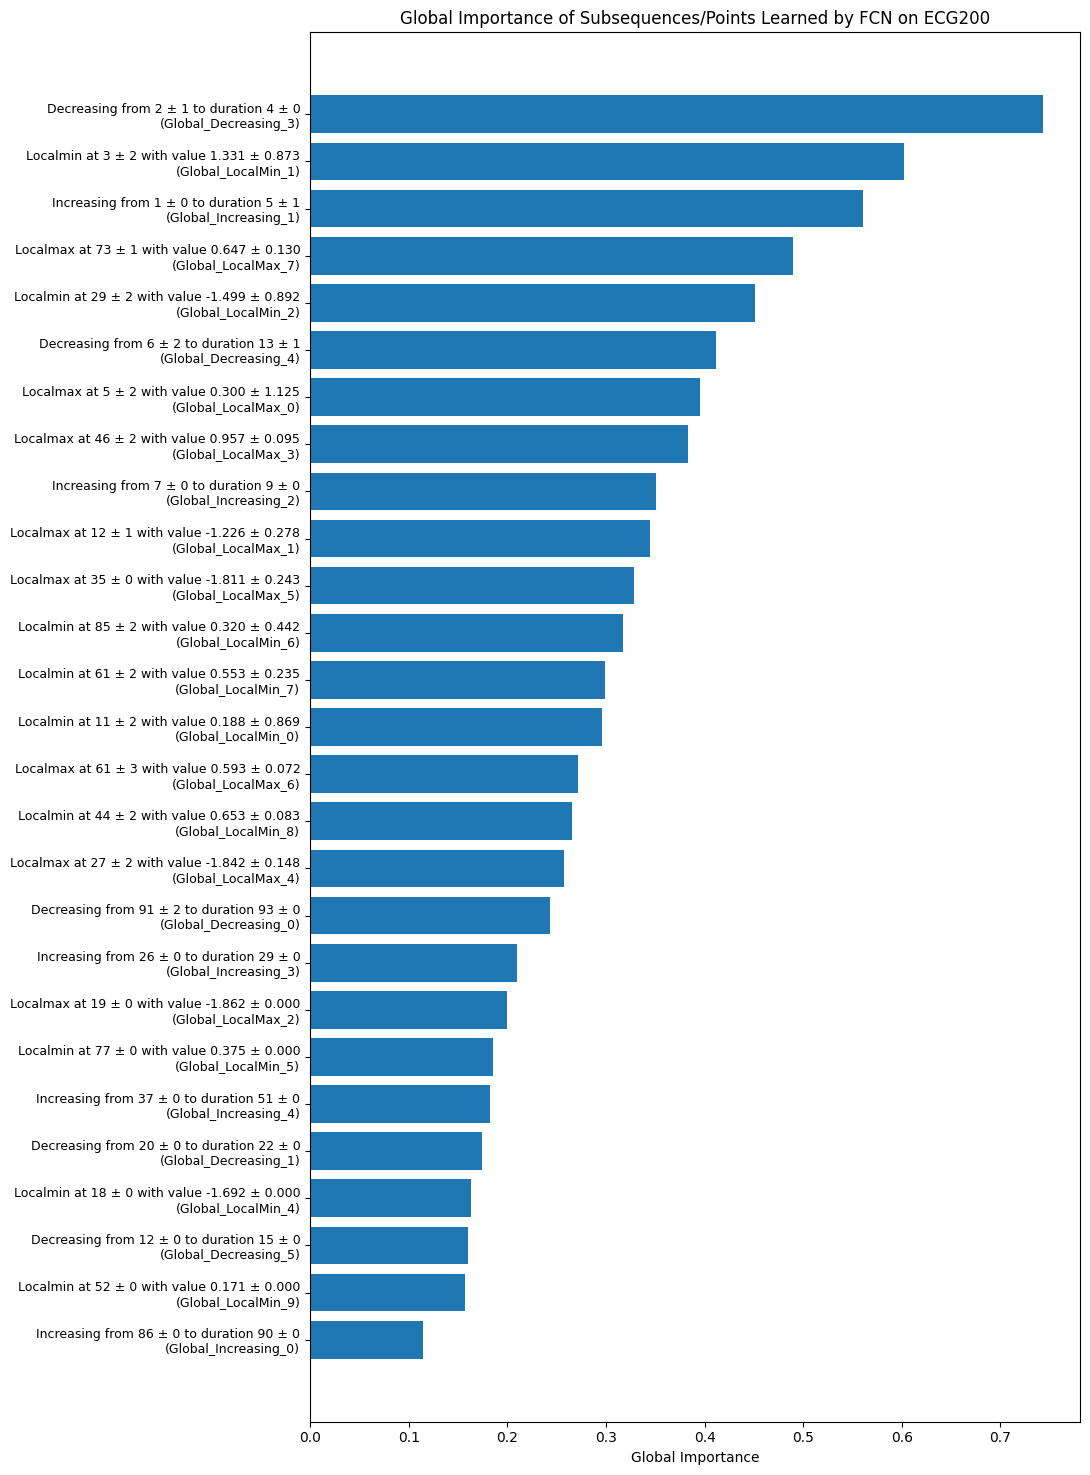

In [81]:
plot_global_summaries(
    global_clusters,
    global_importance,
    summary,
    dataset_name="ECG200",
    model_name="FCN"
)


In [82]:
import matplotlib.pyplot as plt
import numpy as np

def plot_global_summaries(global_clusters, global_importance, summaries, dataset_name, model_name=None):
    """
    Plot only the clusters that are covered in summaries, with numeric importance values.
    """
    # Keep only clusters that exist in the summary
    cluster_info = [
        (cluster, imp, summaries[cluster])
        for cluster, imp in zip(global_clusters, global_importance)
        if cluster in summaries
    ]

    # Sort by importance (descending)
    cluster_info = sorted(cluster_info, key=lambda x: x[1], reverse=True)

    # Unpack
    labels = [f"{summary}" for cluster, _, summary in cluster_info]
    importances = [imp for _, imp, _ in cluster_info]
    

    # Plot
    fig, ax = plt.subplots(figsize=(11, len(labels) * 0.55))
    y_pos = np.arange(len(labels))
    bars = ax.barh(y_pos, importances, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('Global Importance')

    # Add numeric values at the end of bars
    for bar, value in zip(bars, importances):
        ax.text(bar.get_width() + 0.01,  # a bit to the right of the bar
                bar.get_y() + bar.get_height()/2,
                f"{value:.3f}",
                va='center', fontsize=8)

    # Title
    title = f"Global Importance of Event Motifs on {dataset_name}"
    if model_name:
        title = f"Global Importance of Event Motifs Learned by {model_name} on {dataset_name}"
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


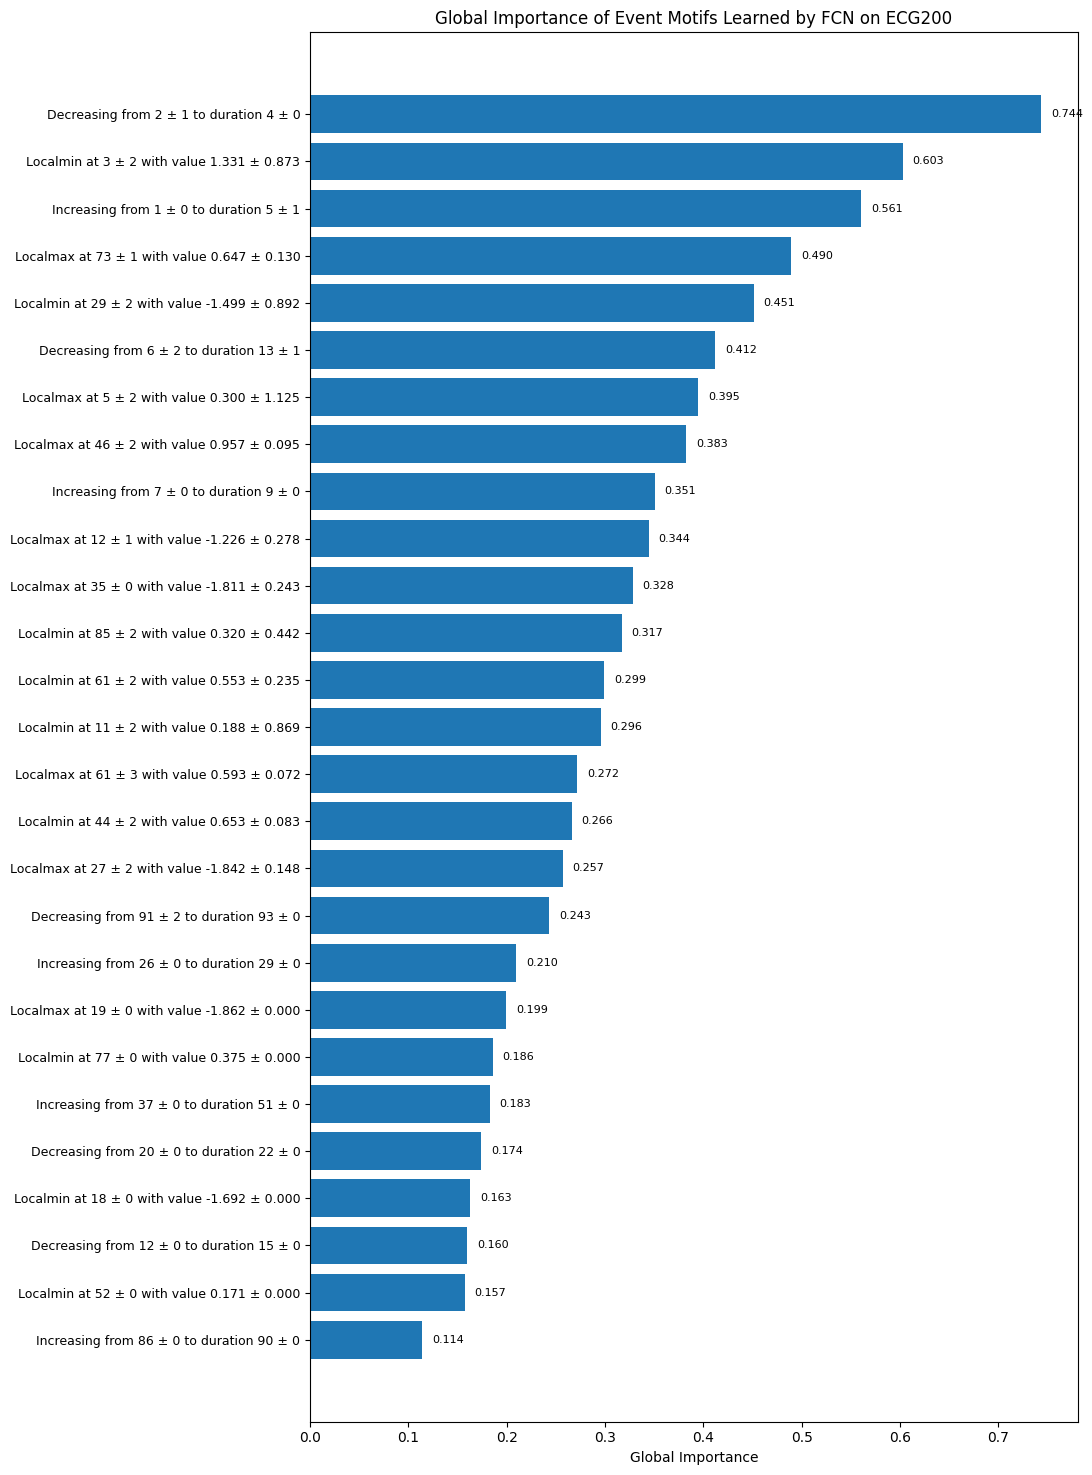

In [83]:
plot_global_summaries(
    global_clusters,
    global_importance,
    summary,
    dataset_name="ECG200",
    model_name="FCN"
)

In [86]:
import matplotlib.pyplot as plt
import numpy as np

def plot_global_summaries(global_clusters, global_importance, summaries, dataset_name, model_name=None):
    """
    Plot only the clusters that are covered in summaries,
    with event-type-based colors and numeric importance values.
    """
    # Keep only clusters that exist in the summary
    cluster_info = [
        (cluster, imp, summaries[cluster])
        for cluster, imp in zip(global_clusters, global_importance)
        if cluster in summaries
    ]

    # Sort by importance (descending)
    cluster_info = sorted(cluster_info, key=lambda x: x[1], reverse=True)

    # Unpack
    labels = [f"{summary}" for cluster, _, summary in cluster_info]
    importances = [imp for _, imp, _ in cluster_info]
    clusters = [c for c, _, _ in cluster_info]

    # Color map by type
    def get_color(cluster_name):
        if "Increasing" in cluster_name:
            return "steelblue"
        elif "Decreasing" in cluster_name:
            return "indianred"
        elif "LocalMax" in cluster_name:
            return "seagreen"
        elif "LocalMin" in cluster_name:
            return "purple"
        return "gray"

    colors = [get_color(c) for c in clusters]

    # Plot
    fig, ax = plt.subplots(figsize=(11, len(labels) * 0.55))
    # y_pos = np.arange(len(labels))
    y_pos = np.arange(len(labels)-1, -1, -1)

    bars = ax.barh(y_pos, importances, align='center', color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=9)
    # ax.invert_yaxis()
    ax.set_xlabel('Global Importance')
    ax.set_ylim(-0.7, len(bars)-0.3)

    # Add numeric values at the end of bars
    for bar, value in zip(bars, importances):
        ax.text(bar.get_width() + 0.01,
                bar.get_y() + bar.get_height()/2,
                f"{value:.3f}",
                va='center', fontsize=8)

    # Title
    title = f"Global Importance of Events on {dataset_name}"
    if model_name:
        title = f"Global Importance of Events Learned by {model_name} on {dataset_name}"
    ax.set_title(title)

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="steelblue", label="Increasing"),
        Patch(facecolor="indianred", label="Decreasing"),
        Patch(facecolor="seagreen", label="LocalMax"),
        Patch(facecolor="purple", label="LocalMin")
    ]
    ax.legend(handles=legend_elements, title="Event Type", loc="lower right")

    plt.tight_layout()
    plt.show()


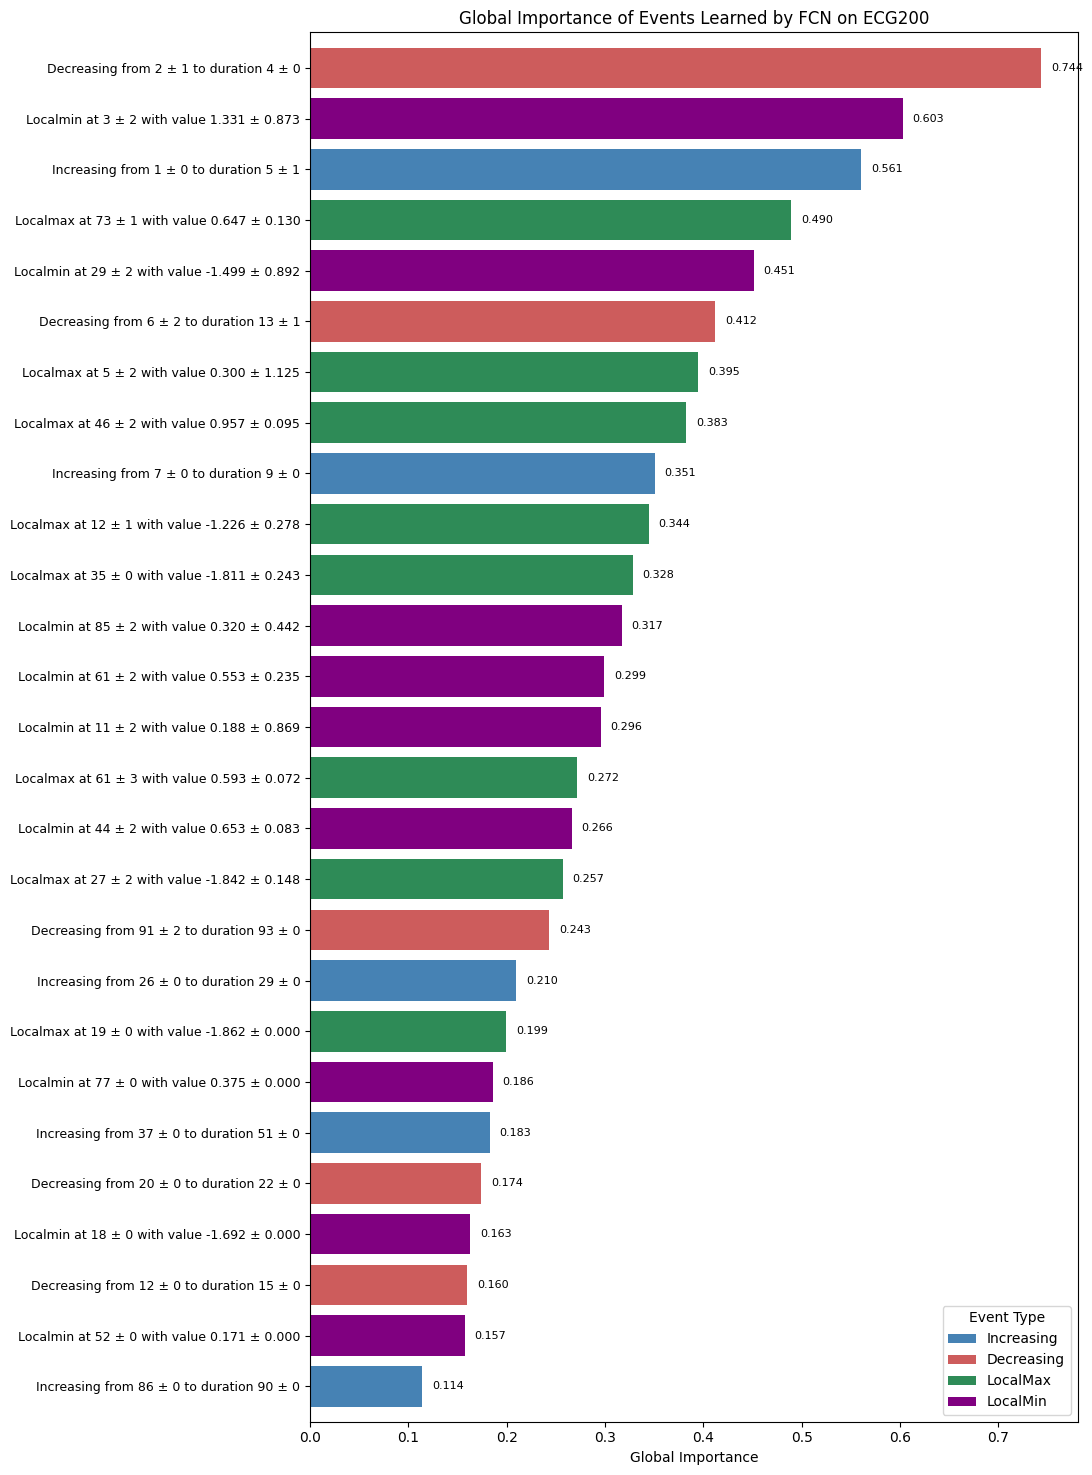

In [87]:
plot_global_summaries(
    global_clusters,
    global_importance,
    summary,
    dataset_name="ECG200",
    model_name="FCN"
)

In [45]:
len(global_clusters)

30

In [47]:
len(global_importance)

30

INFO:lomatce.explainer:Starting time series local explanation


INFO:lomatce.explainer:Perturbed instances shap for classifier: (501, 1, 96)
INFO:lomatce.explainer:Processing events for 501 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 17 = 17
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 16 = 16
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (501, 71) (instances x features)
INFO:lomatce.explainer:Number of instances: 501
INFO:lomatce.explainer:Number of features (clusters): 71


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.95
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.83
INFO:lomatce.explainer:Model Type: Ridge


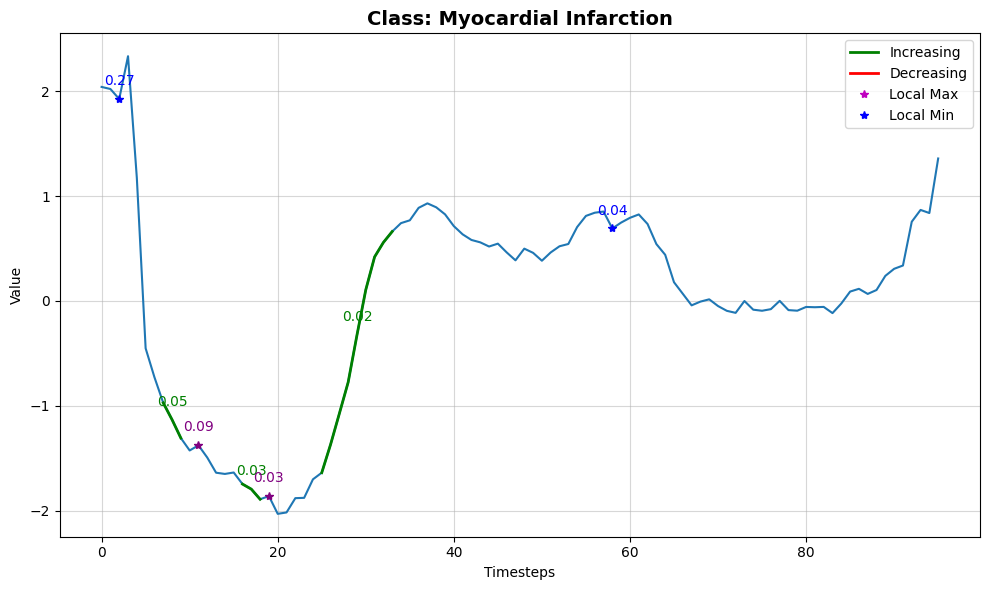

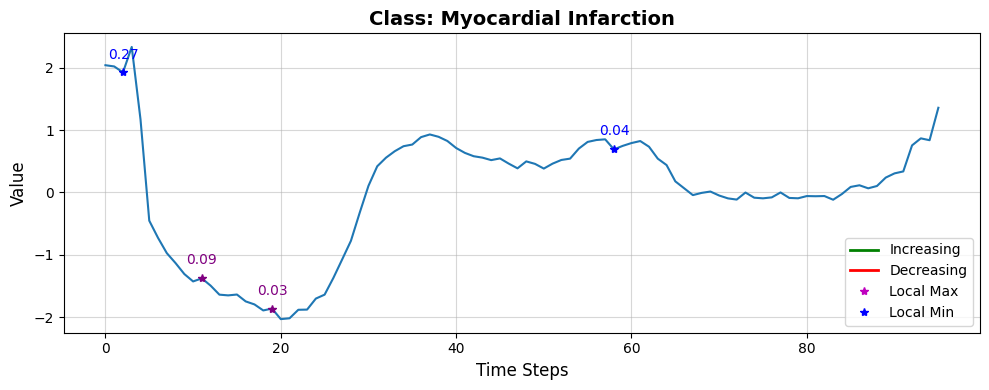

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.8302, 0.1698])
Myocardial Infarction:                      0.8302
Normal Heartbeat:                      0.1698


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 18 = 18
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (1001, 75) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 75


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.92
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.83
INFO:lomatce.explainer:Model Type: Ridge


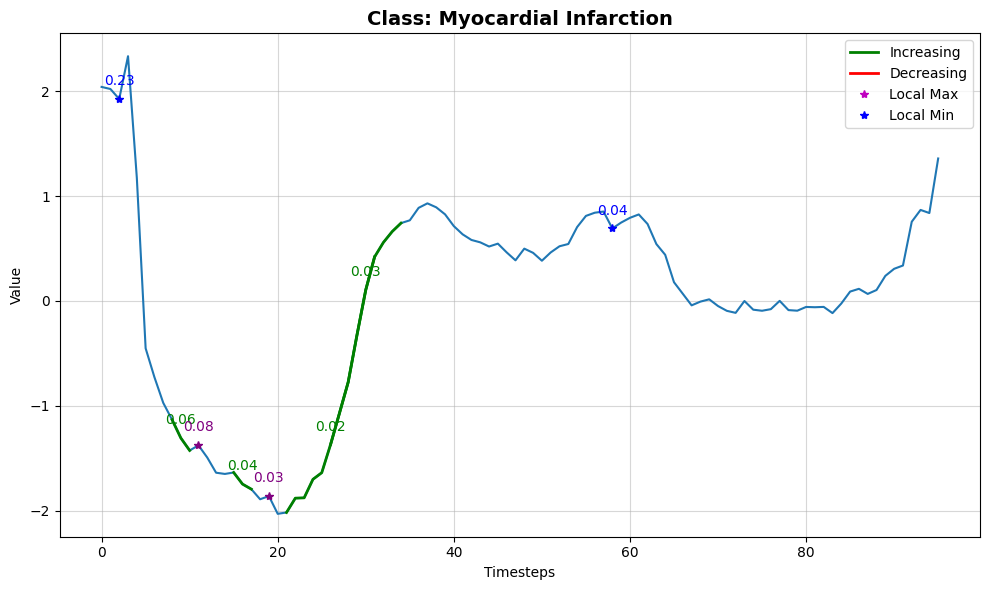

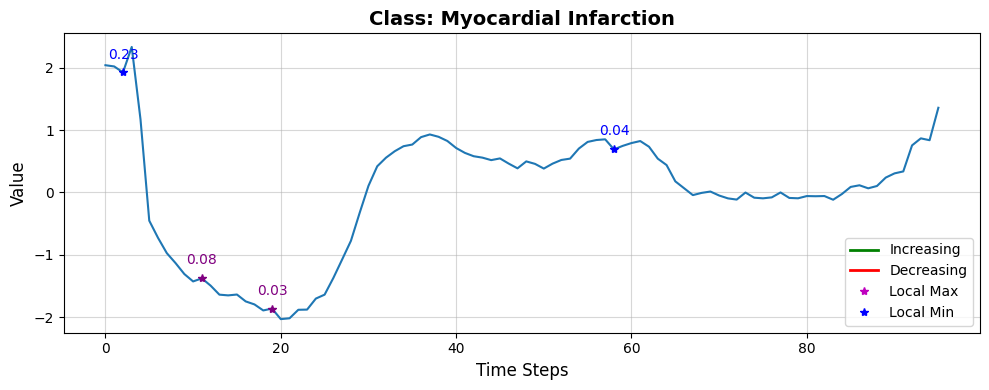

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.8302, 0.1698])
Myocardial Infarction:                      0.8302
Normal Heartbeat:                      0.1698


INFO:lomatce.explainer:Perturbed instances shap for classifier: (501, 1, 96)
INFO:lomatce.explainer:Processing events for 501 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 18 = 18
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 19 = 19


INFO:lomatce.explainer:Final data shape: (501, 75) (instances x features)
INFO:lomatce.explainer:Number of instances: 501
INFO:lomatce.explainer:Number of features (clusters): 75


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.93
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.87
INFO:lomatce.explainer:Model Type: Ridge


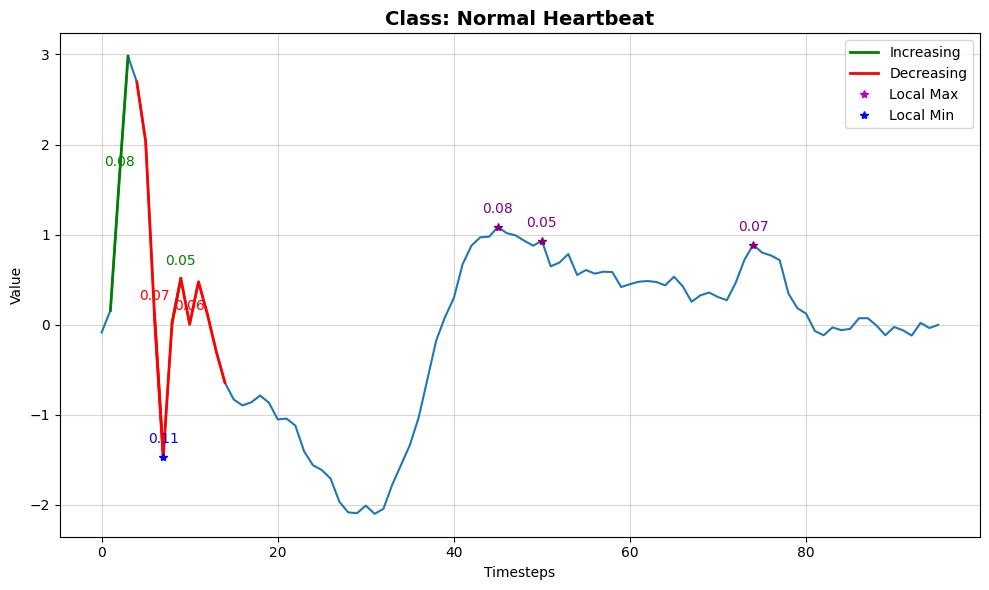

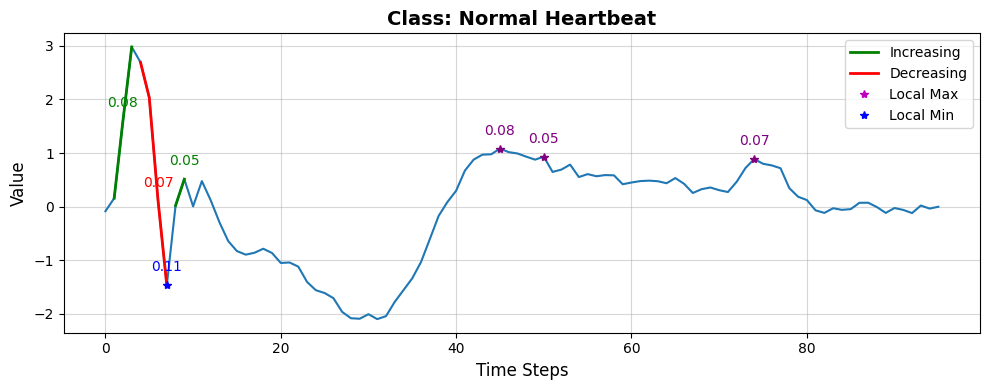

INFO:lomatce.explainer:Starting time series local explanation


Predection probability : tensor([0.1339, 0.8661])
Myocardial Infarction:                      0.1339
Normal Heartbeat:                      0.8661


INFO:lomatce.explainer:Perturbed instances shap for classifier: (1001, 1, 96)
INFO:lomatce.explainer:Processing events for 1001 instances


Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Increasing_ch1: 18 = 18
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for Decreasing_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMax_ch1: 19 = 19
Running on 5 cpu cores (5/20 of total cores)
Optimal number of clusters for LocalMin_ch1: 18 = 18


INFO:lomatce.explainer:Final data shape: (1001, 74) (instances x features)
INFO:lomatce.explainer:Number of instances: 1001
INFO:lomatce.explainer:Number of features (clusters): 74


INFO:lomatce.explainer:Applying linear regression
INFO:lomatce.explainer:R-Score (Local Fidelity): 0.9
INFO:lomatce.explainer:Local Prediction (Linear Model): 0.86
INFO:lomatce.explainer:Model Type: Ridge


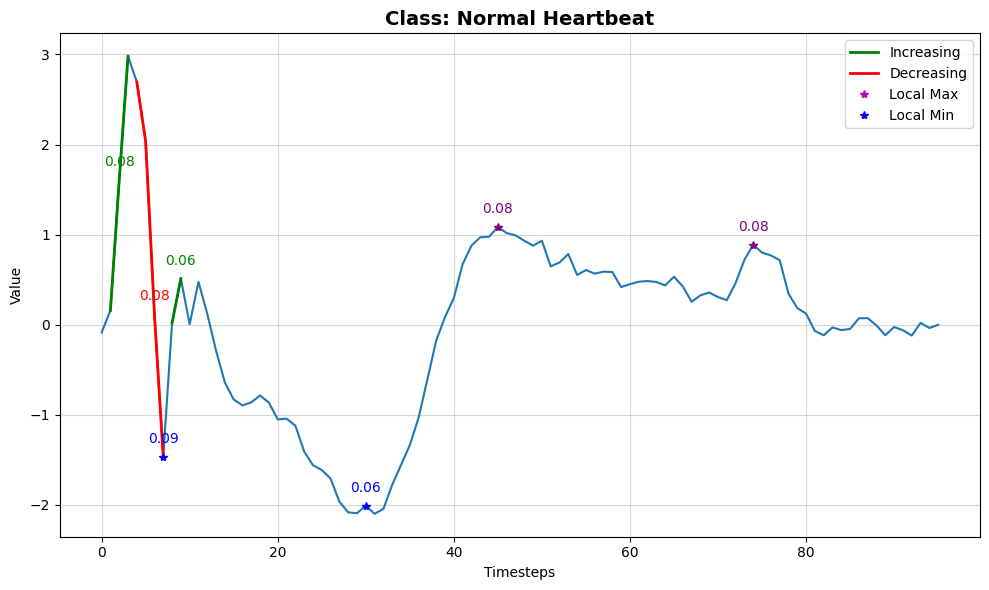

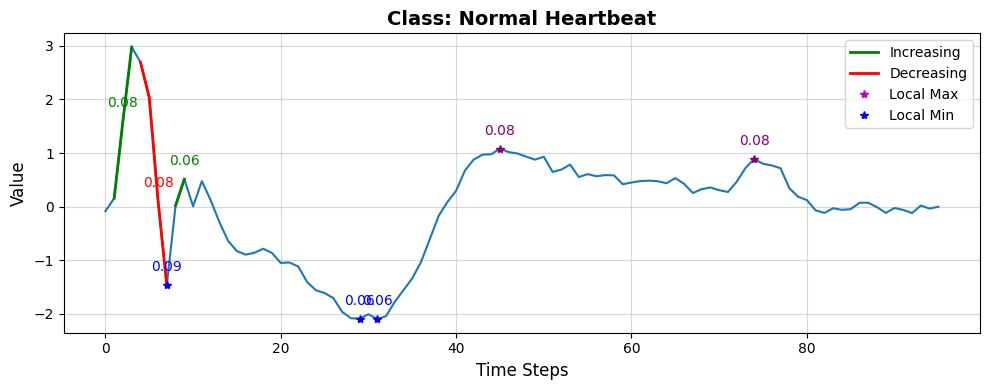

Predection probability : tensor([0.1339, 0.8661])
Myocardial Infarction:                      0.1339
Normal Heartbeat:                      0.8661


TypeError: Object of type int64 is not JSON serializable

In [21]:
import numpy as np
import itertools
import json

# Parameters

num_instances_per_class = 1
kernel_scale_grid = [0.5]
num_perturbations_grid = [500,1000]
seeds = [0]
# replacement_methods = ['zero', 'total_mean']  # optional

# === Select representative instances ===
classes = np.unique(y_test)
selected_idx = []

for cls in classes:
    cls_idx = np.where(y_test == cls)[0]
    chosen = np.random.choice(cls_idx, min(num_instances_per_class, len(cls_idx)), replace=False)
    selected_idx.extend(chosen)

selected_instances = X_test[selected_idx]

# === Run sensitivity grid ===
results = []

for i, instance in enumerate(selected_instances):
    instance_id = selected_idx[i]

    for kernel_scale, num_perturbations, seed in itertools.product(
            kernel_scale_grid, num_perturbations_grid, seeds):
        
        np.random.seed(seed)
        explanation = lomatce_explainer.explain_instance(
            instance,
            lambda data: predict_fn(data, learn_new),
            num_perturbations=num_perturbations,
            class_names=class_labels,
            replacement_method='zero',
            # kernel_scale=kernel_scale
        )
        
        # Force JSON-friendly types
        summary = explanation.get_explanation_summary()
        summary_clean = {
            'local_fidelity': float(summary['local_fidelity']),
            'local_prediction': float(summary['local_prediction']),
            'original_prediction': int(summary['original_prediction']),
            'top_features': {str(k): float(v) for k, v in summary['top_features'].items()}
        }

        results.append({
            'instance_id': instance_id,
            'kernel_scale': float(kernel_scale),
            'num_perturbations': int(num_perturbations),
            'seed': int(seed),
            'explanation_summary': summary_clean
        })

# === Save results ===
with open('lomatce_sensitivity_results_supplementary.json', 'w') as f:
    json.dump(results, f)

print("Sensitivity analysis completed. Results saved to lomatce_sensitivity_results_supplementary.json")

In [22]:
results

[{'instance_id': 4,
  'kernel_scale': 0.5,
  'num_perturbations': 500,
  'seed': 0,
  'explanation_summary': {'local_fidelity': 0.945135847953968,
   'local_prediction': 0.8330133780952963,
   'original_prediction': 0,
   'top_features': {'LocalMin_ch1_c3': 0.2669406580892795,
    'LocalMax_ch1_c2': 0.08757959554915148,
    'Increasing_ch1_c14': 0.05252459203829714,
    'LocalMin_ch1_c8': 0.04436406513758197,
    'Increasing_ch1_c12': 0.029534207378935227,
    'LocalMax_ch1_c7': 0.0280762038866447,
    'Increasing_ch1_c16': 0.0185026625063461}}},
 {'instance_id': 4,
  'kernel_scale': 0.5,
  'num_perturbations': 1000,
  'seed': 0,
  'explanation_summary': {'local_fidelity': 0.9236679274910237,
   'local_prediction': 0.8329570521652855,
   'original_prediction': 0,
   'top_features': {'LocalMin_ch1_c3': 0.23089386782856808,
    'LocalMax_ch1_c10': 0.08247504052705756,
    'Increasing_ch1_c13': 0.057518384949128296,
    'LocalMin_ch1_c5': 0.04384766742656534,
    'Increasing_ch1_c7': 0.04

In [23]:
with open('lomatce_sensitivity_results_supplementary.json', 'w') as f:
    json.dump(results, f, indent=2, default=lambda o: float(o) if hasattr(o, 'dtype') and 'float' in str(o.dtype)
                                                     else int(o) if hasattr(o, 'dtype') and 'int' in str(o.dtype)
                                                     else str(o))


In [26]:
from joblib import Parallel, delayed
import numpy as np
import itertools
import json

# === Sanitization function ===
def sanitize(obj):
    if isinstance(obj, dict):
        return {sanitize(k): sanitize(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [sanitize(x) for x in obj]
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    else:
        return obj

# === Experiment function ===
def run_single_experiment(instance, instance_id, kernel_scale, num_perturbations, seed):
    np.random.seed(seed)
    explanation = lomatce_explainer.explain_instance(
        instance,
        lambda data: predict_fn(data, learn_new),
        num_perturbations=num_perturbations,
        class_names=class_labels,
        replacement_method='zero',
        kernel_scale=kernel_scale
    )

    result = {
        'instance_id': instance_id,
        'kernel_scale': kernel_scale,
        'num_perturbations': num_perturbations,
        'seed': seed,
        'explanation_summary': explanation.get_explanation_summary()
    }

    # Sanitize the result to convert NumPy types
    return sanitize(result)

# === Parameters ===
num_instances_per_class = 1
kernel_scale_grid = [0.5, 1.0,]
num_perturbations_grid = [500]
seeds = [0]

classes = np.unique(y_test)
selected_idx = []
for cls in classes:
    cls_idx = np.where(y_test == cls)[0]
    chosen = np.random.choice(cls_idx, min(num_instances_per_class, len(cls_idx)), replace=False)
    selected_idx.extend(chosen)

selected_instances = X_test[selected_idx]

# === Prepare tasks ===
tasks = []
for i, instance in enumerate(selected_instances):
    instance_id = selected_idx[i]
    for kernel_scale, num_perturbations, seed in itertools.product(kernel_scale_grid, num_perturbations_grid, seeds):
        tasks.append((instance, instance_id, kernel_scale, num_perturbations, seed))

# === Run in parallel ===
results = Parallel(n_jobs=2, verbose=10)(
    delayed(run_single_experiment)(*task) for task in tasks
)

# === Save results safely ===
with open('lomatce_sensitivity_parallel.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Sensitivity analysis completed and saved.")


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done   2 out of   4 | elapsed:  1.2min remaining:  1.2min


Sensitivity analysis completed and saved.


[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:  3.4min finished
